<h1 style="text-align: center;"> Reto II: Comparación de un modelo base a uno pre-entrenado.  </h1>
<p align="center">
  <img src="https://cdn.prod.website-files.com/649475f4d573d5d9d1522659/649475f4d573d5d9d1522705_logo-track-ciencia.webp" alt="Logo Track Ciencia">
</p>

**Contexto del caso**

El caso de uso trata sobre un conjunto de datos de imágenes de un supermercado de diversos productos en donde el objetivo se centra en una tarea de clasificación de imágenes para poder predecir sobre 3 productos (multi-label).

**Objetivos del reto**

- Este reto busca que los estudiantes comparen el rendimiento de la red CNN vista en clase DL_Semana2_GroceryStore con una red pre-entrenada **ResNet50** o **MobileNetV2** (a elección del estudiante). 

El propósito es analizar como los modelos preentrenados se comportan respecto a una red construida desde cero en el dataset trabajado anteriormente en clase.
- Elige uno de los dos modelos **ResNet50** o **MobileNetV2**, y luego, agrega capas extra a un clasificador final, por ejemplo:

GlobalAveragePooling2D + Dense Softmax
- Entrenar solo el clasificador final.

- El alumno deberá escribir un pequeño análisis respondiendo:

1. ¿Cuál modelo obtuvo mejor f1-score y por qué?
2. ¿Qué tan diferente fue el tiempo de entrenamiento?
3. ¿Qué ventajas observas al usar modelos preentrenados?
4. ¿Hay riesgo de sobre-ajuste en alguno de los modelos?

# Librerias

In [1]:
import os
import cv2
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input

from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, f1_score, confusion_matrix

import matplotlib.pyplot as plt


# Dataset

In [2]:
data_dir = "/Users/danielml/Documents/Computational/Curso_Bourbaki/Math_Deep_Learning/Semana_2/GroceryStoreDataset/dataset"
img_size = (180, 180)
batch_size = 32
seed = 42

In [3]:
df_classes = pd.read_csv(data_dir + "/classes.csv")
df_classes.sample(5)

,Class Name (str),Class ID (int),Coarse Class Name (str),Coarse Class ID (int),Iconic Image Path (str),Product Description Path (str)
44,Oatly-Natural-Oatghurt,44,Oatghurt,21,/iconic-images-and-descriptions/Packages/Oatgh...,/iconic-images-and-descriptions/Packages/Oatgh...
60,Aubergine,60,Aubergine,29,/iconic-images-and-descriptions/Vegetables/Aub...,/iconic-images-and-descriptions/Vegetables/Aub...
61,Cabbage,61,Cabbage,30,/iconic-images-and-descriptions/Vegetables/Cab...,/iconic-images-and-descriptions/Vegetables/Cab...
23,Pineapple,23,Pineapple,14,/iconic-images-and-descriptions/Fruit/Pineappl...,/iconic-images-and-descriptions/Fruit/Pineappl...
64,Garlic,64,Garlic,33,/iconic-images-and-descriptions/Vegetables/Gar...,/iconic-images-and-descriptions/Vegetables/Gar...


In [4]:
df_classes.shape

(81, 6)

In [5]:
df_classes.groupby(["Coarse Class ID (int)", "Coarse Class Name (str)"]).size()

Coarse Class ID (int)  Coarse Class Name (str)
0                      Apple                       5
1                      Avocado                     1
2                      Banana                      1
3                      Kiwi                        1
4                      Lemon                       1
5                      Lime                        1
6                      Mango                       1
7                      Melon                       4
8                      Nectarine                   1
9                      Orange                      1
10                     Papaya                      1
11                     Passion-Fruit               1
12                     Peach                       1
13                     Pear                        3
14                     Pineapple                   1
15                     Plum                        1
16                     Pomegranate                 1
17                     Red-Grapefruit              1

In [6]:
coarse_mapping = dict(df_classes[['Coarse Class ID (int)', 'Coarse Class Name (str)']].drop_duplicates().values)

In [7]:
filter_img = [0, 1, 2]

In [8]:
coarse_mapping = {k: v for k, v in coarse_mapping.items() if k in filter_img}
coarse_mapping

{0: 'Apple', 1: 'Avocado', 2: 'Banana'}

In [9]:
df_train = pd.read_csv(data_dir + "/train.txt", names = ['path','fine','coarse'])
df_val = pd.read_csv(data_dir + "/val.txt", names = ['path','fine','coarse'])
df_test = pd.read_csv(data_dir + "/test.txt", names = ['path','fine','coarse'])

In [10]:
df_train = df_train[df_train['coarse'].isin(filter_img)]
df_val = df_val[df_val['coarse'].isin(filter_img)]
df_test = df_test[df_test['coarse'].isin(filter_img)]

In [11]:
df_train.sample(5)

,path,fine,coarse
52,train/Fruit/Apple/Granny-Smith/Granny-Smith_00...,1,0
185,train/Fruit/Apple/Red-Delicious/Red-Delicious_...,3,0
187,train/Fruit/Apple/Red-Delicious/Red-Delicious_...,3,0
357,train/Fruit/Banana/Banana_039.jpg,6,2
215,train/Fruit/Apple/Royal-Gala/Royal-Gala_003.jpg,4,0


In [12]:
image = cv2.imread(data_dir + '/train/Fruit/Apple/Golden-Delicious/Golden-Delicious_001.jpg')
image.shape

(348, 348, 3)

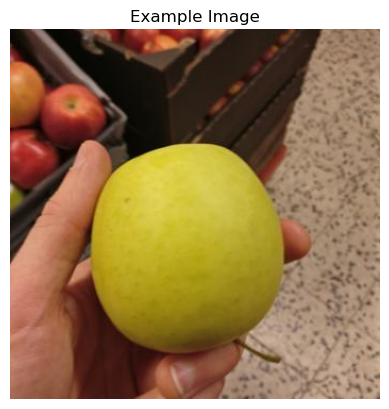

In [13]:
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.imshow(image_rgb)
plt.title('Example Image')
plt.axis('off')
plt.show()

In [14]:
df_train["coarse_name"] = df_train["coarse"].map(coarse_mapping)
counts = df_train["coarse_name"].value_counts()

In [15]:
counts

coarse_name
Apple      278
Banana      45
Avocado     41
Name: count, dtype: int64

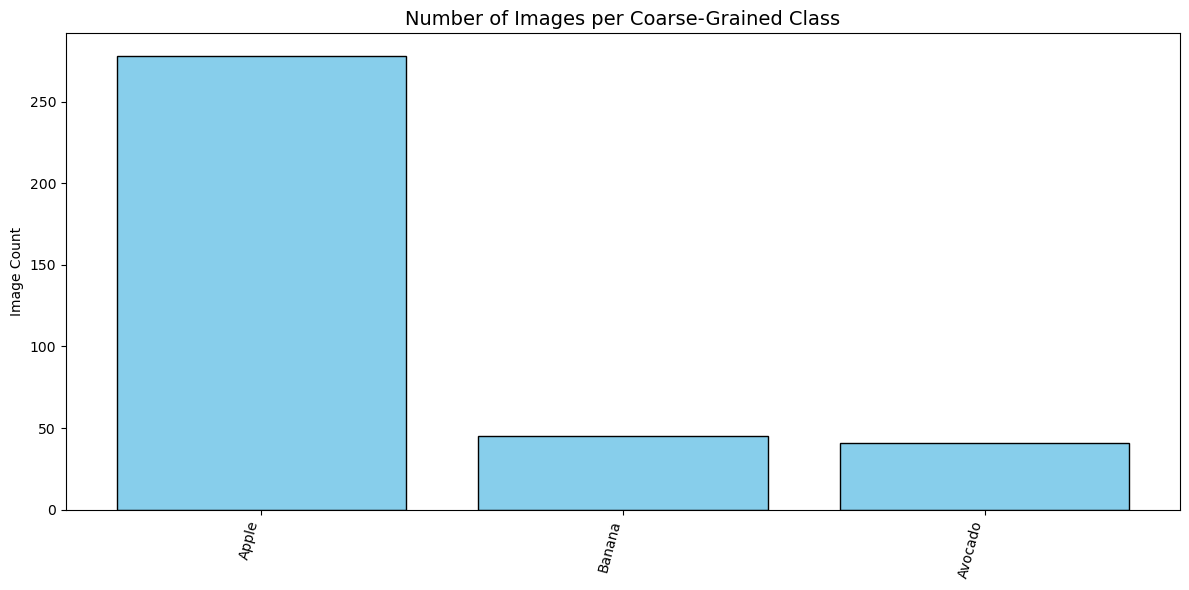

In [16]:
plt.figure(figsize=(12, 6))
plt.bar(counts.index, counts.values, color="skyblue", edgecolor="black")
plt.title("Number of Images per Coarse-Grained Class", fontsize=14)
plt.ylabel("Image Count")
plt.xticks(rotation=75, ha="right")
plt.tight_layout()
plt.show()

# Cargar conjunto de datos con Train/ Val / Test

In [17]:
def load_images_from_folder(paths):
    image_ds = []
    for path in paths:
        s = data_dir + '/' + path
        img = cv2.imread(s)
        resized = cv2.resize(img, img_size)
        image_ds.append(resized)
        
    image_array = np.array(image_ds)
    X = image_array / 255               # Normalizamos para que los valores de los pixeles estén en [0, 1]
    return X


In [18]:
X_train = load_images_from_folder(df_train['path'].values)
X_val = load_images_from_folder(df_val['path'].values)
X_test = load_images_from_folder(df_test['path'].values)

In [19]:
X_train.shape

(364, 180, 180, 3)

In [20]:
X_val.shape

(33, 180, 180, 3)

In [21]:
X_test.shape

(360, 180, 180, 3)

In [22]:
y_train = np.array(df_train['coarse'])
y_val = np.array(df_val['coarse'])
y_test = np.array(df_test['coarse'])

In [23]:
train_counts = dict(zip(counts.index, counts.values))

In [24]:
train_counts

{'Apple': 278, 'Banana': 45, 'Avocado': 41}

## Balanceo del conjunto de datos

In [25]:
class_counts = Counter(y_train)
print('Distribucion de clases original')
print(class_counts)

Distribucion de clases original
Counter({0: 278, 2: 45, 1: 41})


In [26]:
max_count = max(class_counts.values())
max_count

278

## Creamos generador de Data Augmentation

In [27]:
datagen = ImageDataGenerator(
    rotation_range = 50,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    zoom_range = 0.2,
    horizontal_flip = True,
    brightness_range = [0.8, 1.2],
    fill_mode = 'nearest'
)

In [28]:
y_train

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [29]:
np.unique(y_train)

array([0, 1, 2])

## Oversampling dinámico

In [30]:
X_aug = []
y_aug = []

for cls in np.unique(y_train):
    idx = np.where(y_train == cls)[0]
    X_cls = X_train[idx]
    n_current = len(X_cls)
    n_to_generate = 1500                # max_count - n_current
    
    if n_to_generate > 0:
        print(f"Clase {cls}: generando {n_to_generate} imágenes aumentadas")
        gen = datagen.flow(X_cls, batch_size = 1)
        
        for i in range(n_to_generate):
            new_img = next(gen)[0]
            X_aug.append(new_img)
            y_aug.append(cls)
    

Clase 0: generando 1500 imágenes aumentadas
Clase 1: generando 1500 imágenes aumentadas
Clase 2: generando 1500 imágenes aumentadas


## Combinamos el dataset original + aumentado 

In [31]:
if X_aug:
    X_aug = np.array(X_aug)
    y_aug = np.array(y_aug)
    X_train_balanced = np.concatenate([X_train, X_aug], axis = 0)
    y_train_balanced = np.concatenate([y_train, y_aug], axis = 0)
    
else:
    X_train_balanced, y_train_balanced = X_train, y_train

print("\nDistribución balanceada final:")
print(Counter(y_train_balanced))


Distribución balanceada final:
Counter({0: 1778, 2: 1545, 1: 1541})


## Generamos una permutación aleatoria de indices

In [32]:
permutation = np.random.permutation(len(X_train_balanced))

# Aplicamos la permutacion a X e Y
X_train_balanced = X_train_balanced[permutation]
y_train_balanced = y_train_balanced[permutation]

In [33]:
permutation

array([2501, 4111, 1167, ..., 3786, 2970, 1677])

# Data Augmentation

In [34]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.5),
    layers.RandomZoom(0.2),
])

2025-12-09 12:39:58.889071: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2025-12-09 12:39:58.889303: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-12-09 12:39:58.889322: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.92 GB
2025-12-09 12:39:58.889368: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-12-09 12:39:58.889535: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


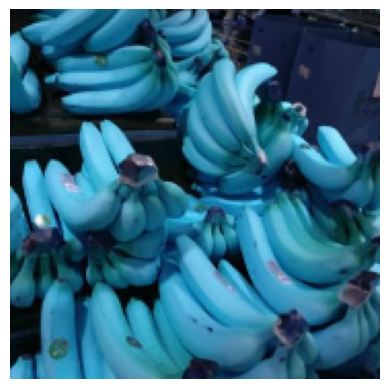

In [35]:
plt.axis('off')
plt.imshow(X_train[360])

2025-12-09 12:39:59.468832: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:39:59.596328: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


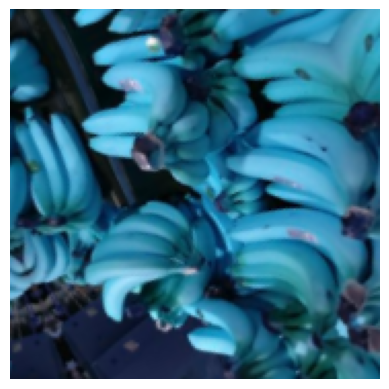

In [36]:
plt.axis('off')
plt.imshow(data_augmentation(X_train)[360])

In [37]:
num_classes = len(coarse_mapping)
num_classes

3

In [38]:
img_size + (3, )

(180, 180, 3)

# Cargamos el modelo trabajado en Clase.

In [39]:
baseline_model = load_model("./models/cnn_grocery_story.h5")
baseline_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 180, 180, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 180, 180, 32)      128       
 Normalization)                                                  
                                                                 
 re_lu (ReLU)                (None, 180, 180, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 64)        18496     
                                                                 
 batch_normalization_1 (Bat  (None, 90, 90, 64)       

In [40]:
y_probs_base = baseline_model.predict(X_test)
y_preds_base = np.argmax(y_probs_base, axis=1)

 1/12 [=>............................] - ETA: 3s

2025-12-09 12:40:00.681738: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


12/12 [==============================] - 1s 23ms/step


In [41]:
print("--- Baseline (CNN desde cero) ---")
print(classification_report(y_test, y_preds_base))
f1_base = f1_score(y_test, y_preds_base, average='weighted')
print(f"Weighted F1 (baseline): {f1_base:.4f}")

--- Baseline (CNN desde cero) ---
              precision    recall  f1-score   support

           0       0.93      0.94      0.93       276
           1       0.81      0.85      0.83        40
           2       0.66      0.57      0.61        44

    accuracy                           0.88       360
   macro avg       0.80      0.79      0.79       360
weighted avg       0.88      0.88      0.88       360

Weighted F1 (baseline): 0.8809


# Cargamos el modelo preentrenado ResNet50

In [42]:
inputs = tf.keras.Input(shape=img_size + (3,))

In [43]:
x = data_augmentation(inputs) 

In [44]:
# Re-escalamiento de [0, 1] a [0, 255] para que ResNet50 reciba lo que espera ya que anteriormente me entrenó
# solo la clase mayoritaria y dejó en 0's a las otras clases.
x = x * 255.0


In [45]:
# Preprocesamiento específico de ResNet50
x = preprocess_input(x)

In [46]:
# Base preentrenada en ImageNet
base_model = ResNet50(
    include_top = False,
    weights = "imagenet",
    input_tensor = x,
    pooling = "avg" 
)

In [47]:
base_model.trainable = False

In [48]:
x = base_model.output
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)

In [49]:
tl_model = tf.keras.Model(inputs, outputs)
tl_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 180, 180, 3)]        0         []                            
                                                                                                  
 sequential (Sequential)     (None, 180, 180, 3)          0         ['input_1[0][0]']             
                                                                                                  
 tf.math.multiply (TFOpLamb  (None, 180, 180, 3)          0         ['sequential[0][0]']          
 da)                                                                                              
                                                                                                  
 tf.__operators__.getitem (  (None, 180, 180, 3)          0         ['tf.math.multiply[0][0]']

# Compilamos el modelo de ResNet50

In [50]:
tl_model.compile(
    optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=1e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# Entrenamos el modelo de ResNet50

In [51]:
num_epochs = 30  

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.3,
    patience=2
)

history_tl = tl_model.fit(
    X_train_balanced, y_train_balanced,
    validation_data=(X_val, y_val),
    epochs=num_epochs,
    batch_size=32,
    callbacks=[early_stop, reduce_lr]
)

Epoch 1/30


2025-12-09 12:40:08.864483: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:08.879059: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  2/152 [..............................] - ETA: 21s - loss: 1.5042 - accuracy: 0.3594 

2025-12-09 12:40:09.628780: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:09.640545: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:09.768789: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:09.768812: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  4/152 [..............................] - ETA: 18s - loss: 1.4001 - accuracy: 0.3438

2025-12-09 12:40:09.882868: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:09.883126: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:10.001825: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:10.001863: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  6/152 [>.............................] - ETA: 19s - loss: 1.3456 - accuracy: 0.3385

2025-12-09 12:40:10.123188: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:10.123467: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:10.286141: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:10.287166: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  8/152 [>.............................] - ETA: 18s - loss: 1.2657 - accuracy: 0.3750

2025-12-09 12:40:10.399596: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:10.399936: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:10.513167: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:10.513832: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 10/152 [>.............................] - ETA: 17s - loss: 1.2446 - accuracy: 0.4062

2025-12-09 12:40:10.625436: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:10.626353: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:10.739625: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:10.739740: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 12/152 [=>............................] - ETA: 17s - loss: 1.2372 - accuracy: 0.4036

2025-12-09 12:40:10.854622: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:10.854816: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:10.967959: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:10.968294: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 14/152 [=>............................] - ETA: 16s - loss: 1.2369 - accuracy: 0.4018

2025-12-09 12:40:11.081193: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:11.081361: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:11.195343: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:11.195568: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 16/152 [==>...........................] - ETA: 16s - loss: 1.2271 - accuracy: 0.3984

2025-12-09 12:40:11.307558: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:11.307690: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:11.421585: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:11.421721: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 18/152 [==>...........................] - ETA: 15s - loss: 1.2238 - accuracy: 0.3924

2025-12-09 12:40:11.535207: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:11.535304: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:11.649284: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:11.649292: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 20/152 [==>...........................] - ETA: 15s - loss: 1.2368 - accuracy: 0.3938

2025-12-09 12:40:11.760879: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:11.761243: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:11.875735: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:11.875918: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 22/152 [===>..........................] - ETA: 15s - loss: 1.2330 - accuracy: 0.3906

2025-12-09 12:40:11.987644: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:11.988017: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:12.103118: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:12.103411: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 24/152 [===>..........................] - ETA: 15s - loss: 1.2324 - accuracy: 0.3893

2025-12-09 12:40:12.217642: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:12.217663: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:12.333070: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:12.333410: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 26/152 [====>.........................] - ETA: 14s - loss: 1.2303 - accuracy: 0.3906

2025-12-09 12:40:12.446866: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:12.447322: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:12.567275: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:12.567394: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 28/152 [====>.........................] - ETA: 14s - loss: 1.2334 - accuracy: 0.3884

2025-12-09 12:40:12.684413: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:12.684501: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:12.800613: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:12.801036: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 30/152 [====>.........................] - ETA: 14s - loss: 1.2315 - accuracy: 0.3812

2025-12-09 12:40:12.914761: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:12.914869: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:13.064776: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:13.065128: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 32/152 [=====>........................] - ETA: 14s - loss: 1.2310 - accuracy: 0.3828

2025-12-09 12:40:13.179924: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:13.180546: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:13.297816: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:13.299253: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 34/152 [=====>........................] - ETA: 14s - loss: 1.2265 - accuracy: 0.3814

2025-12-09 12:40:13.433359: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:13.433764: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:13.550967: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:13.551515: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 36/152 [======>.......................] - ETA: 13s - loss: 1.2140 - accuracy: 0.3872

2025-12-09 12:40:13.666880: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:13.667463: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:13.786708: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:13.786967: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 38/152 [======>.......................] - ETA: 13s - loss: 1.2045 - accuracy: 0.3914

2025-12-09 12:40:13.902932: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:13.903355: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:14.021036: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:14.021174: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 40/152 [======>.......................] - ETA: 13s - loss: 1.1991 - accuracy: 0.3898

2025-12-09 12:40:14.138496: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:14.138637: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:14.254771: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:14.255441: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 42/152 [=======>......................] - ETA: 13s - loss: 1.1971 - accuracy: 0.3899

2025-12-09 12:40:14.398541: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:14.408473: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:14.524800: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:14.525042: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 44/152 [=======>......................] - ETA: 12s - loss: 1.1888 - accuracy: 0.3906

2025-12-09 12:40:14.639221: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:14.639686: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:14.755100: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:14.755393: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 46/152 [========>.....................] - ETA: 12s - loss: 1.1895 - accuracy: 0.3899

2025-12-09 12:40:14.871729: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:14.871742: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:14.988061: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:14.989593: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 48/152 [========>.....................] - ETA: 12s - loss: 1.1802 - accuracy: 0.3958

2025-12-09 12:40:15.106231: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:15.107901: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:15.233393: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:15.233412: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 50/152 [========>.....................] - ETA: 12s - loss: 1.1810 - accuracy: 0.3981

2025-12-09 12:40:15.351737: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:15.352092: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:15.468044: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:15.468555: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 52/152 [=========>....................] - ETA: 11s - loss: 1.1764 - accuracy: 0.3996

2025-12-09 12:40:15.582453: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:15.582879: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:15.699097: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:15.699302: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 54/152 [=========>....................] - ETA: 11s - loss: 1.1765 - accuracy: 0.3970

2025-12-09 12:40:15.841547: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:15.842601: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:15.970276: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:15.970319: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 56/152 [==========>...................] - ETA: 11s - loss: 1.1822 - accuracy: 0.3940

2025-12-09 12:40:16.084125: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:16.084542: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:16.199839: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:16.200124: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 58/152 [==========>...................] - ETA: 11s - loss: 1.1811 - accuracy: 0.3928

2025-12-09 12:40:16.312319: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:16.313300: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:16.427708: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:16.429863: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 60/152 [==========>...................] - ETA: 10s - loss: 1.1837 - accuracy: 0.3938

2025-12-09 12:40:16.543438: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:16.543644: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:16.659368: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:16.659746: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 62/152 [===========>..................] - ETA: 10s - loss: 1.1799 - accuracy: 0.3957

2025-12-09 12:40:16.772495: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:16.773717: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:16.889063: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:16.889075: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 64/152 [===========>..................] - ETA: 10s - loss: 1.1796 - accuracy: 0.3950

2025-12-09 12:40:17.002399: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:17.002574: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:17.118711: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:17.118973: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 66/152 [============>.................] - ETA: 10s - loss: 1.1821 - accuracy: 0.3935

2025-12-09 12:40:17.231535: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:17.231786: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:17.350100: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:17.350376: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 68/152 [============>.................] - ETA: 9s - loss: 1.1839 - accuracy: 0.3911 

2025-12-09 12:40:17.464250: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:17.464725: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:17.581076: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:17.581078: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 70/152 [============>.................] - ETA: 9s - loss: 1.1820 - accuracy: 0.3906

2025-12-09 12:40:17.696617: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:17.697836: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:17.814759: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:17.814781: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 72/152 [=============>................] - ETA: 9s - loss: 1.1837 - accuracy: 0.3898

2025-12-09 12:40:17.929886: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:17.930351: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:18.046935: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:18.047435: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 74/152 [=============>................] - ETA: 9s - loss: 1.1810 - accuracy: 0.3910

2025-12-09 12:40:18.160505: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:18.160885: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:18.278139: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:18.278250: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 76/152 [==============>...............] - ETA: 9s - loss: 1.1774 - accuracy: 0.3935

2025-12-09 12:40:18.408725: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:18.409817: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:18.525370: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:18.525688: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 78/152 [==============>...............] - ETA: 8s - loss: 1.1742 - accuracy: 0.3946

2025-12-09 12:40:18.640991: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:18.641547: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:18.758265: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:18.758273: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 80/152 [==============>...............] - ETA: 8s - loss: 1.1729 - accuracy: 0.3961

2025-12-09 12:40:18.871191: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:18.871211: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:18.985413: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:18.985423: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 82/152 [===============>..............] - ETA: 8s - loss: 1.1714 - accuracy: 0.3967

2025-12-09 12:40:19.109531: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:19.110424: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:19.226761: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:19.226828: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 84/152 [===============>..............] - ETA: 8s - loss: 1.1696 - accuracy: 0.3966

2025-12-09 12:40:19.345676: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:19.345749: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:19.471812: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:19.472055: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 86/152 [===============>..............] - ETA: 7s - loss: 1.1679 - accuracy: 0.3957

2025-12-09 12:40:19.594403: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:19.594852: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:19.753591: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:19.754356: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 88/152 [================>.............] - ETA: 7s - loss: 1.1677 - accuracy: 0.3945

2025-12-09 12:40:19.867391: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:19.867638: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:19.985737: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:19.985754: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 90/152 [================>.............] - ETA: 7s - loss: 1.1662 - accuracy: 0.3948

2025-12-09 12:40:20.099006: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:20.099287: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:20.213197: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:20.213382: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 92/152 [=================>............] - ETA: 7s - loss: 1.1658 - accuracy: 0.3944

2025-12-09 12:40:20.328964: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:20.329016: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:20.444370: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:20.444428: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 94/152 [=================>............] - ETA: 6s - loss: 1.1634 - accuracy: 0.3946

2025-12-09 12:40:20.556767: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:20.559305: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:20.673830: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:20.674282: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 96/152 [=================>............] - ETA: 6s - loss: 1.1597 - accuracy: 0.3962

2025-12-09 12:40:20.786966: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:20.787052: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:20.902639: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:20.903195: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 98/152 [==================>...........] - ETA: 6s - loss: 1.1582 - accuracy: 0.3967

2025-12-09 12:40:21.016923: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:21.017034: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:21.132948: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:21.133332: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


100/152 [==================>...........] - ETA: 6s - loss: 1.1587 - accuracy: 0.3963

2025-12-09 12:40:21.252343: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:21.252360: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:21.368276: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:21.368669: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


102/152 [===================>..........] - ETA: 5s - loss: 1.1567 - accuracy: 0.3974

2025-12-09 12:40:21.483541: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:21.483671: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:21.600118: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:21.600223: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


104/152 [===================>..........] - ETA: 5s - loss: 1.1572 - accuracy: 0.3957

2025-12-09 12:40:21.712703: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:21.712771: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:21.831771: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:21.832070: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


106/152 [===================>..........] - ETA: 5s - loss: 1.1559 - accuracy: 0.3968

2025-12-09 12:40:21.945332: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:21.945608: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:22.061935: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:22.062234: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


108/152 [====================>.........] - ETA: 5s - loss: 1.1526 - accuracy: 0.3979

2025-12-09 12:40:22.174162: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:22.174796: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:22.290364: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:22.291427: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


110/152 [====================>.........] - ETA: 4s - loss: 1.1508 - accuracy: 0.3989

2025-12-09 12:40:22.403356: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:22.403696: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:22.517538: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:22.517791: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


112/152 [=====================>........] - ETA: 4s - loss: 1.1511 - accuracy: 0.3987

2025-12-09 12:40:22.630715: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:22.631221: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:22.757841: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:22.758029: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


114/152 [=====================>........] - ETA: 4s - loss: 1.1497 - accuracy: 0.3978

2025-12-09 12:40:22.870528: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:22.871451: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:22.987577: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:22.987851: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


116/152 [=====================>........] - ETA: 4s - loss: 1.1471 - accuracy: 0.3992

2025-12-09 12:40:23.150445: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:23.151058: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:23.268839: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:23.268970: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


118/152 [======================>.......] - ETA: 4s - loss: 1.1463 - accuracy: 0.3988

2025-12-09 12:40:23.384007: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:23.384133: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:23.500614: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:23.500717: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


120/152 [======================>.......] - ETA: 3s - loss: 1.1465 - accuracy: 0.3997

2025-12-09 12:40:23.613768: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:23.614274: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:23.730645: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:23.731169: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


122/152 [=======================>......] - ETA: 3s - loss: 1.1441 - accuracy: 0.4006

2025-12-09 12:40:23.844203: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:23.844615: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:23.959166: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:23.959184: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


124/152 [=======================>......] - ETA: 3s - loss: 1.1426 - accuracy: 0.4005

2025-12-09 12:40:24.079272: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:24.079470: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:24.215054: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:24.215370: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


126/152 [=======================>......] - ETA: 3s - loss: 1.1439 - accuracy: 0.4000

2025-12-09 12:40:24.333693: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:24.336021: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:24.452697: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:24.453096: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


128/152 [========================>.....] - ETA: 2s - loss: 1.1421 - accuracy: 0.4001

2025-12-09 12:40:24.607394: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:24.607466: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:24.727611: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:24.728033: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


130/152 [========================>.....] - ETA: 2s - loss: 1.1405 - accuracy: 0.3998

2025-12-09 12:40:24.841801: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:24.841956: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:24.956735: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:24.957318: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


132/152 [=========================>....] - ETA: 2s - loss: 1.1395 - accuracy: 0.4001

2025-12-09 12:40:25.071026: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:25.071779: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:25.188957: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:25.189978: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


134/152 [=========================>....] - ETA: 2s - loss: 1.1371 - accuracy: 0.4009

2025-12-09 12:40:25.303847: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:25.304155: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:25.419938: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:25.420268: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


136/152 [=========================>....] - ETA: 1s - loss: 1.1362 - accuracy: 0.4007

2025-12-09 12:40:25.535037: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:25.535425: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:25.650087: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:25.650588: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


138/152 [==========================>...] - ETA: 1s - loss: 1.1350 - accuracy: 0.4006

2025-12-09 12:40:25.766509: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:25.766664: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:25.884827: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:25.885335: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


140/152 [==========================>...] - ETA: 1s - loss: 1.1347 - accuracy: 0.4000

2025-12-09 12:40:26.002889: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:26.004777: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:26.128682: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:26.129070: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


142/152 [===========================>..] - ETA: 1s - loss: 1.1328 - accuracy: 0.4010

2025-12-09 12:40:26.244804: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:26.246798: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:26.363917: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:26.364080: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


144/152 [===========================>..] - ETA: 0s - loss: 1.1318 - accuracy: 0.4010

2025-12-09 12:40:26.479761: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:26.480172: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:26.614535: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:26.614551: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


146/152 [===========================>..] - ETA: 0s - loss: 1.1316 - accuracy: 0.4003

2025-12-09 12:40:26.727392: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:26.727739: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:26.842223: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:26.842343: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


148/152 [============================>.] - ETA: 0s - loss: 1.1330 - accuracy: 0.3999

2025-12-09 12:40:26.955756: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:26.955779: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:27.069349: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:27.069453: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


150/152 [============================>.] - ETA: 0s - loss: 1.1330 - accuracy: 0.3981

2025-12-09 12:40:27.183396: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:27.183878: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:27.299038: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:27.299051: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


152/152 [==============================] - ETA: 0s - loss: 1.1315 - accuracy: 0.3982

2025-12-09 12:40:27.411095: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:27.411203: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


152/152 [==============================] - 22s 130ms/step - loss: 1.1315 - accuracy: 0.3982 - val_loss: 0.3068 - val_accuracy: 0.9091 - lr: 1.0000e-04
Epoch 2/30
  1/152 [..............................] - ETA: 21s - loss: 1.0711 - accuracy: 0.3125

2025-12-09 12:40:29.218414: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:29.218535: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:29.357352: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:29.357501: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  3/152 [..............................] - ETA: 20s - loss: 1.1269 - accuracy: 0.3646

2025-12-09 12:40:29.508879: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:29.509023: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:29.626519: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:29.627045: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  5/152 [..............................] - ETA: 18s - loss: 1.0944 - accuracy: 0.3938

2025-12-09 12:40:29.742265: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:29.742271: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:29.858179: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:29.858302: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  7/152 [>.............................] - ETA: 17s - loss: 1.0878 - accuracy: 0.4018

2025-12-09 12:40:29.986112: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:29.986259: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:30.101263: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:30.101282: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  9/152 [>.............................] - ETA: 17s - loss: 1.0719 - accuracy: 0.4132

2025-12-09 12:40:30.215686: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:30.216268: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:30.333451: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:30.334534: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 11/152 [=>............................] - ETA: 17s - loss: 1.0805 - accuracy: 0.3920

2025-12-09 12:40:30.488055: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:30.488489: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:30.603329: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:30.603890: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 13/152 [=>............................] - ETA: 17s - loss: 1.0719 - accuracy: 0.4038

2025-12-09 12:40:30.720201: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:30.720366: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:30.835771: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:30.836285: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 15/152 [=>............................] - ETA: 16s - loss: 1.0610 - accuracy: 0.4083

2025-12-09 12:40:30.948838: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:30.950479: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:31.066122: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:31.066215: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 17/152 [==>...........................] - ETA: 16s - loss: 1.0584 - accuracy: 0.4044

2025-12-09 12:40:31.183439: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:31.184098: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:31.301878: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:31.302340: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 19/152 [==>...........................] - ETA: 16s - loss: 1.0563 - accuracy: 0.4062

2025-12-09 12:40:31.418944: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:31.418991: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:31.537630: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:31.538597: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 21/152 [===>..........................] - ETA: 15s - loss: 1.0490 - accuracy: 0.4122

2025-12-09 12:40:31.654096: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:31.654603: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:31.770970: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:31.771316: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 23/152 [===>..........................] - ETA: 15s - loss: 1.0569 - accuracy: 0.4049

2025-12-09 12:40:31.886678: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:31.887074: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:32.002041: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:32.002149: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 25/152 [===>..........................] - ETA: 15s - loss: 1.0576 - accuracy: 0.4025

2025-12-09 12:40:32.115706: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:32.116274: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:32.231010: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:32.231804: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 27/152 [====>.........................] - ETA: 14s - loss: 1.0511 - accuracy: 0.4086

2025-12-09 12:40:32.343476: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:32.344862: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:32.459560: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:32.460192: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 29/152 [====>.........................] - ETA: 14s - loss: 1.0450 - accuracy: 0.4170

2025-12-09 12:40:32.572483: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:32.573033: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:32.688889: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:32.689244: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 31/152 [=====>........................] - ETA: 14s - loss: 1.0459 - accuracy: 0.4133

2025-12-09 12:40:32.806269: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:32.806759: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:32.923437: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:32.923445: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 33/152 [=====>........................] - ETA: 14s - loss: 1.0408 - accuracy: 0.4176

2025-12-09 12:40:33.078173: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:33.078214: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:33.202018: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:33.202251: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 35/152 [=====>........................] - ETA: 14s - loss: 1.0394 - accuracy: 0.4170

2025-12-09 12:40:33.315664: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:33.316931: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:33.432351: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:33.432401: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 37/152 [======>.......................] - ETA: 13s - loss: 1.0392 - accuracy: 0.4155

2025-12-09 12:40:33.544774: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:33.545510: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:33.659559: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:33.659711: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 39/152 [======>.......................] - ETA: 13s - loss: 1.0386 - accuracy: 0.4175

2025-12-09 12:40:33.771395: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:33.771421: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:33.887294: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:33.887410: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 41/152 [=======>......................] - ETA: 13s - loss: 1.0401 - accuracy: 0.4207

2025-12-09 12:40:33.999126: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:34.001164: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:34.115148: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:34.115183: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 43/152 [=======>......................] - ETA: 12s - loss: 1.0383 - accuracy: 0.4259

2025-12-09 12:40:34.227815: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:34.228300: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:34.343540: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:34.343992: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 45/152 [=======>......................] - ETA: 12s - loss: 1.0385 - accuracy: 0.4250

2025-12-09 12:40:34.457102: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:34.457536: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:34.623723: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:34.623810: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 47/152 [========>.....................] - ETA: 12s - loss: 1.0408 - accuracy: 0.4255

2025-12-09 12:40:34.739136: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:34.739363: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:34.854084: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:34.854109: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 49/152 [========>.....................] - ETA: 12s - loss: 1.0481 - accuracy: 0.4222

2025-12-09 12:40:34.969568: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:34.969652: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:35.086622: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:35.086866: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 51/152 [=========>....................] - ETA: 12s - loss: 1.0434 - accuracy: 0.4259

2025-12-09 12:40:35.201722: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:35.203274: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:35.318668: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:35.318856: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 53/152 [=========>....................] - ETA: 11s - loss: 1.0429 - accuracy: 0.4245

2025-12-09 12:40:35.432275: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:35.432321: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:35.548640: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:35.548941: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 55/152 [=========>....................] - ETA: 11s - loss: 1.0429 - accuracy: 0.4239

2025-12-09 12:40:35.661528: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:35.662146: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:35.777276: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:35.778096: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 57/152 [==========>...................] - ETA: 11s - loss: 1.0423 - accuracy: 0.4227

2025-12-09 12:40:35.889972: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:35.890300: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:36.004308: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:36.004825: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 59/152 [==========>...................] - ETA: 11s - loss: 1.0422 - accuracy: 0.4211

2025-12-09 12:40:36.161127: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:36.161509: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:36.275316: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:36.275475: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 61/152 [===========>..................] - ETA: 10s - loss: 1.0417 - accuracy: 0.4185

2025-12-09 12:40:36.391038: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:36.391538: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:36.509786: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:36.510152: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 63/152 [===========>..................] - ETA: 10s - loss: 1.0403 - accuracy: 0.4196

2025-12-09 12:40:36.624598: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:36.624716: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:36.739907: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:36.740870: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 65/152 [===========>..................] - ETA: 10s - loss: 1.0386 - accuracy: 0.4202

2025-12-09 12:40:36.854244: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:36.854349: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:36.973474: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:36.973514: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 67/152 [============>.................] - ETA: 10s - loss: 1.0366 - accuracy: 0.4221

2025-12-09 12:40:37.101226: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:37.101442: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:37.219753: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:37.219963: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 69/152 [============>.................] - ETA: 9s - loss: 1.0363 - accuracy: 0.4194 

2025-12-09 12:40:37.366059: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:37.366446: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:37.490762: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:37.490794: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 71/152 [=============>................] - ETA: 9s - loss: 1.0342 - accuracy: 0.4203

2025-12-09 12:40:37.605100: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:37.605207: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:37.720991: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:37.721675: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 73/152 [=============>................] - ETA: 9s - loss: 1.0320 - accuracy: 0.4221

2025-12-09 12:40:37.833769: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:37.839266: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:37.953640: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:37.953646: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 75/152 [=============>................] - ETA: 9s - loss: 1.0315 - accuracy: 0.4238

2025-12-09 12:40:38.067183: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:38.067985: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:38.182932: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:38.183015: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 77/152 [==============>...............] - ETA: 8s - loss: 1.0314 - accuracy: 0.4233

2025-12-09 12:40:38.295924: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:38.296795: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:38.411187: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:38.411570: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 79/152 [==============>...............] - ETA: 8s - loss: 1.0327 - accuracy: 0.4209

2025-12-09 12:40:38.523093: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:38.523618: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:38.637742: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:38.638012: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 81/152 [==============>...............] - ETA: 8s - loss: 1.0316 - accuracy: 0.4244

2025-12-09 12:40:38.783358: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:38.791722: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:38.914141: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:38.914279: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 83/152 [===============>..............] - ETA: 8s - loss: 1.0296 - accuracy: 0.4258

2025-12-09 12:40:39.030274: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:39.030843: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:39.146894: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:39.147277: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 85/152 [===============>..............] - ETA: 7s - loss: 1.0274 - accuracy: 0.4272

2025-12-09 12:40:39.259289: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:39.260344: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:39.376994: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:39.377205: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 87/152 [================>.............] - ETA: 7s - loss: 1.0286 - accuracy: 0.4264

2025-12-09 12:40:39.489820: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:39.489962: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:39.605629: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:39.606196: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 89/152 [================>.............] - ETA: 7s - loss: 1.0290 - accuracy: 0.4259

2025-12-09 12:40:39.719397: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:39.719588: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:39.833518: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:39.834729: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 91/152 [================>.............] - ETA: 7s - loss: 1.0285 - accuracy: 0.4275

2025-12-09 12:40:39.948863: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:39.949589: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:40.065229: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:40.065622: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 93/152 [=================>............] - ETA: 7s - loss: 1.0264 - accuracy: 0.4304

2025-12-09 12:40:40.178745: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:40.179437: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:40.295928: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:40.296400: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 95/152 [=================>............] - ETA: 6s - loss: 1.0281 - accuracy: 0.4273

2025-12-09 12:40:40.442140: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:40.443785: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:40.566518: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:40.566904: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 97/152 [==================>...........] - ETA: 6s - loss: 1.0259 - accuracy: 0.4288

2025-12-09 12:40:40.680642: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:40.680902: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:40.796259: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:40.796722: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 99/152 [==================>...........] - ETA: 6s - loss: 1.0270 - accuracy: 0.4277

2025-12-09 12:40:40.912676: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:40.913122: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:41.028000: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:41.028467: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


101/152 [==================>...........] - ETA: 6s - loss: 1.0264 - accuracy: 0.4279

2025-12-09 12:40:41.150295: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:41.151441: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:41.266777: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:41.266947: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


103/152 [===================>..........] - ETA: 5s - loss: 1.0255 - accuracy: 0.4272

2025-12-09 12:40:41.392021: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:41.393387: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:41.508416: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:41.509326: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


105/152 [===================>..........] - ETA: 5s - loss: 1.0265 - accuracy: 0.4259

2025-12-09 12:40:41.621265: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:41.621452: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:41.736235: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:41.736372: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


107/152 [====================>.........] - ETA: 5s - loss: 1.0293 - accuracy: 0.4232

2025-12-09 12:40:41.883161: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:41.883611: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:42.003182: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:42.003199: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


109/152 [====================>.........] - ETA: 5s - loss: 1.0288 - accuracy: 0.4232

2025-12-09 12:40:42.116620: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:42.116684: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:42.231782: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:42.231966: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


111/152 [====================>.........] - ETA: 4s - loss: 1.0295 - accuracy: 0.4243

2025-12-09 12:40:42.346302: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:42.346717: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:42.463477: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:42.463601: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


113/152 [=====================>........] - ETA: 4s - loss: 1.0301 - accuracy: 0.4237

2025-12-09 12:40:42.577129: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:42.577759: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:42.695286: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:42.695302: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


115/152 [=====================>........] - ETA: 4s - loss: 1.0298 - accuracy: 0.4231

2025-12-09 12:40:42.809660: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:42.810558: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:42.929516: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:42.929887: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


117/152 [======================>.......] - ETA: 4s - loss: 1.0303 - accuracy: 0.4209

2025-12-09 12:40:43.078219: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:43.078619: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:43.191784: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:43.192122: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


119/152 [======================>.......] - ETA: 3s - loss: 1.0301 - accuracy: 0.4210

2025-12-09 12:40:43.314261: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:43.314661: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:43.430114: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:43.431736: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


121/152 [======================>.......] - ETA: 3s - loss: 1.0306 - accuracy: 0.4210

2025-12-09 12:40:43.545836: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:43.546821: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:43.681489: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:43.681760: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


123/152 [=======================>......] - ETA: 3s - loss: 1.0278 - accuracy: 0.4230

2025-12-09 12:40:43.795782: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:43.797844: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:43.915296: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:43.915823: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


125/152 [=======================>......] - ETA: 3s - loss: 1.0276 - accuracy: 0.4232

2025-12-09 12:40:44.028538: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:44.028720: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:44.143862: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:44.143871: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


127/152 [========================>.....] - ETA: 2s - loss: 1.0272 - accuracy: 0.4240

2025-12-09 12:40:44.256648: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:44.257216: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:44.419187: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:44.419504: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


129/152 [========================>.....] - ETA: 2s - loss: 1.0265 - accuracy: 0.4239

2025-12-09 12:40:44.534369: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:44.534891: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:44.651809: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:44.651858: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


131/152 [========================>.....] - ETA: 2s - loss: 1.0260 - accuracy: 0.4251

2025-12-09 12:40:44.772512: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:44.772985: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:44.899929: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:44.900794: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


133/152 [=========================>....] - ETA: 2s - loss: 1.0267 - accuracy: 0.4246

2025-12-09 12:40:45.015119: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:45.015963: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:45.131334: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:45.131344: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


135/152 [=========================>....] - ETA: 2s - loss: 1.0267 - accuracy: 0.4243

2025-12-09 12:40:45.246034: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:45.246591: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:45.363988: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:45.364118: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


137/152 [==========================>...] - ETA: 1s - loss: 1.0256 - accuracy: 0.4243

2025-12-09 12:40:45.476632: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:45.476731: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:45.592731: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:45.592751: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


139/152 [==========================>...] - ETA: 1s - loss: 1.0262 - accuracy: 0.4245

2025-12-09 12:40:45.706473: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:45.706539: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:45.822002: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:45.822018: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


141/152 [==========================>...] - ETA: 1s - loss: 1.0265 - accuracy: 0.4246

2025-12-09 12:40:45.942573: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:45.942747: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:46.060607: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:46.060774: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


143/152 [===========================>..] - ETA: 1s - loss: 1.0263 - accuracy: 0.4240

2025-12-09 12:40:46.173845: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:46.174074: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:46.291179: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:46.291552: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


145/152 [===========================>..] - ETA: 0s - loss: 1.0253 - accuracy: 0.4241

2025-12-09 12:40:46.443742: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:46.446630: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:46.560445: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:46.560758: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


147/152 [============================>.] - ETA: 0s - loss: 1.0235 - accuracy: 0.4245

2025-12-09 12:40:46.673557: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:46.673571: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:46.789102: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:46.789280: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


149/152 [============================>.] - ETA: 0s - loss: 1.0257 - accuracy: 0.4230

2025-12-09 12:40:46.902333: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:46.902658: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:47.018163: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:47.018533: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


151/152 [============================>.] - ETA: 0s - loss: 1.0267 - accuracy: 0.4228

2025-12-09 12:40:47.129961: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:47.131190: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:47.247750: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:47.247820: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


152/152 [==============================] - 18s 121ms/step - loss: 1.0264 - accuracy: 0.4235 - val_loss: 0.1145 - val_accuracy: 0.9394 - lr: 1.0000e-04
Epoch 3/30
  1/152 [..............................] - ETA: 19s - loss: 1.0156 - accuracy: 0.4062

2025-12-09 12:40:47.688352: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:47.688474: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:47.816699: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:47.816881: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  3/152 [..............................] - ETA: 17s - loss: 0.9995 - accuracy: 0.4271

2025-12-09 12:40:47.932345: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:47.932912: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:48.046516: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:48.046470: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  5/152 [..............................] - ETA: 16s - loss: 0.9785 - accuracy: 0.4750

2025-12-09 12:40:48.159381: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:48.160071: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:48.275081: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:48.275140: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  7/152 [>.............................] - ETA: 16s - loss: 1.0185 - accuracy: 0.4643

2025-12-09 12:40:48.388074: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:48.388550: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:48.503419: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:48.503590: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  9/152 [>.............................] - ETA: 16s - loss: 1.0211 - accuracy: 0.4549

2025-12-09 12:40:48.616852: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:48.616946: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:48.749205: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:48.749424: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 11/152 [=>............................] - ETA: 16s - loss: 1.0499 - accuracy: 0.4233

2025-12-09 12:40:48.863873: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:48.864144: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:48.981220: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:48.981776: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 13/152 [=>............................] - ETA: 16s - loss: 1.0459 - accuracy: 0.4351

2025-12-09 12:40:49.094700: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:49.095572: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:49.213869: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:49.214520: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 15/152 [=>............................] - ETA: 15s - loss: 1.0417 - accuracy: 0.4354

2025-12-09 12:40:49.327504: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:49.329453: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:49.449900: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:49.449929: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 17/152 [==>...........................] - ETA: 17s - loss: 1.0349 - accuracy: 0.4467

2025-12-09 12:40:49.720490: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:49.720932: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:49.906673: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:49.907216: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 18/152 [==>...........................] - ETA: 19s - loss: 1.0302 - accuracy: 0.4427

2025-12-09 12:40:50.254014: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:50.254657: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 19/152 [==>...........................] - ETA: 19s - loss: 1.0309 - accuracy: 0.4424

2025-12-09 12:40:50.510118: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:50.510979: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 21/152 [===>..........................] - ETA: 20s - loss: 1.0375 - accuracy: 0.4375

2025-12-09 12:40:50.749348: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:50.750370: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:50.884508: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:50.884938: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 23/152 [===>..........................] - ETA: 19s - loss: 1.0345 - accuracy: 0.4375

2025-12-09 12:40:50.997786: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:50.998185: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:51.113193: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:51.113300: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 25/152 [===>..........................] - ETA: 18s - loss: 1.0293 - accuracy: 0.4400

2025-12-09 12:40:51.226153: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:51.226541: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:51.358274: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:51.358279: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 27/152 [====>.........................] - ETA: 18s - loss: 1.0274 - accuracy: 0.4340

2025-12-09 12:40:51.481048: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:51.481675: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:51.597000: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:51.597058: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 29/152 [====>.........................] - ETA: 17s - loss: 1.0317 - accuracy: 0.4300

2025-12-09 12:40:51.709947: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:51.710119: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:51.823085: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:51.824169: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 31/152 [=====>........................] - ETA: 17s - loss: 1.0257 - accuracy: 0.4345

2025-12-09 12:40:51.936531: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:51.936949: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:52.051489: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:52.051509: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 33/152 [=====>........................] - ETA: 16s - loss: 1.0236 - accuracy: 0.4366

2025-12-09 12:40:52.164824: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:52.165446: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:52.280225: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:52.280374: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 35/152 [=====>........................] - ETA: 16s - loss: 1.0199 - accuracy: 0.4357

2025-12-09 12:40:52.394865: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:52.395522: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:52.511734: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:52.511875: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 37/152 [======>.......................] - ETA: 15s - loss: 1.0191 - accuracy: 0.4324

2025-12-09 12:40:52.625824: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:52.625859: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:52.744312: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:52.744492: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 39/152 [======>.......................] - ETA: 15s - loss: 1.0218 - accuracy: 0.4311

2025-12-09 12:40:52.859152: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:52.860028: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:52.975670: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:52.975816: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 41/152 [=======>......................] - ETA: 15s - loss: 1.0153 - accuracy: 0.4337

2025-12-09 12:40:53.089319: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:53.089715: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:53.267060: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:53.268320: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 43/152 [=======>......................] - ETA: 14s - loss: 1.0150 - accuracy: 0.4360

2025-12-09 12:40:53.382343: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:53.382663: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:53.495262: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:53.495318: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 45/152 [=======>......................] - ETA: 14s - loss: 1.0149 - accuracy: 0.4333

2025-12-09 12:40:53.608979: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:53.609587: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:53.724229: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:53.724476: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 47/152 [========>.....................] - ETA: 14s - loss: 1.0154 - accuracy: 0.4335

2025-12-09 12:40:53.837543: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:53.837572: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:53.952638: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:53.953206: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 49/152 [========>.....................] - ETA: 13s - loss: 1.0149 - accuracy: 0.4362

2025-12-09 12:40:54.074394: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:54.075076: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:54.190648: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:54.191138: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 51/152 [=========>....................] - ETA: 13s - loss: 1.0111 - accuracy: 0.4357

2025-12-09 12:40:54.305998: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:54.307130: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:54.425160: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:54.426240: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 53/152 [=========>....................] - ETA: 13s - loss: 1.0093 - accuracy: 0.4375

2025-12-09 12:40:54.540219: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:54.540559: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:54.696180: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:54.696270: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 55/152 [=========>....................] - ETA: 12s - loss: 1.0060 - accuracy: 0.4403

2025-12-09 12:40:54.809787: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:54.809927: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:54.924941: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:54.924952: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 57/152 [==========>...................] - ETA: 12s - loss: 1.0106 - accuracy: 0.4380

2025-12-09 12:40:55.039746: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:55.039774: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:55.156328: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:55.156362: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 59/152 [==========>...................] - ETA: 12s - loss: 1.0114 - accuracy: 0.4396

2025-12-09 12:40:55.271682: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:55.272099: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:55.406808: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:55.407083: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 61/152 [===========>..................] - ETA: 11s - loss: 1.0147 - accuracy: 0.4385

2025-12-09 12:40:55.522633: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:55.522992: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:55.639115: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:55.639204: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 63/152 [===========>..................] - ETA: 11s - loss: 1.0163 - accuracy: 0.4380

2025-12-09 12:40:55.790984: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:55.798190: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:55.912471: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:55.912508: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 65/152 [===========>..................] - ETA: 11s - loss: 1.0159 - accuracy: 0.4399

2025-12-09 12:40:56.027187: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:56.027251: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:56.145026: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:56.145157: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 67/152 [============>.................] - ETA: 11s - loss: 1.0154 - accuracy: 0.4398

2025-12-09 12:40:56.257318: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:56.258609: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:56.373905: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:56.374425: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 69/152 [============>.................] - ETA: 10s - loss: 1.0126 - accuracy: 0.4407

2025-12-09 12:40:56.487140: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:56.487292: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:56.602615: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:56.603237: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 71/152 [=============>................] - ETA: 10s - loss: 1.0122 - accuracy: 0.4406

2025-12-09 12:40:56.716378: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:56.716608: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:56.832129: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:56.832214: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 73/152 [=============>................] - ETA: 10s - loss: 1.0109 - accuracy: 0.4414

2025-12-09 12:40:56.945113: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:56.945261: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:57.060503: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:57.061321: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 75/152 [=============>................] - ETA: 9s - loss: 1.0104 - accuracy: 0.4429 

2025-12-09 12:40:57.175822: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:57.176612: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:57.295179: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:57.295601: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 77/152 [==============>...............] - ETA: 9s - loss: 1.0108 - accuracy: 0.4412

2025-12-09 12:40:57.409171: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:57.409475: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:57.530205: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:57.530613: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 79/152 [==============>...............] - ETA: 9s - loss: 1.0116 - accuracy: 0.4407

2025-12-09 12:40:57.643708: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:57.643931: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:57.760606: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:57.760600: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 81/152 [==============>...............] - ETA: 9s - loss: 1.0115 - accuracy: 0.4402

2025-12-09 12:40:57.873719: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:57.873800: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:57.990325: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:57.990347: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 83/152 [===============>..............] - ETA: 8s - loss: 1.0121 - accuracy: 0.4375

2025-12-09 12:40:58.103010: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:58.103371: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:58.257728: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:58.257869: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 85/152 [===============>..............] - ETA: 8s - loss: 1.0128 - accuracy: 0.4375

2025-12-09 12:40:58.370996: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:58.371625: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:58.484879: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:58.485266: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 87/152 [================>.............] - ETA: 8s - loss: 1.0108 - accuracy: 0.4389

2025-12-09 12:40:58.598209: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:58.599226: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:58.715696: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:58.715998: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 89/152 [================>.............] - ETA: 7s - loss: 1.0110 - accuracy: 0.4379

2025-12-09 12:40:58.828745: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:58.829352: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:58.951225: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:58.951343: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 91/152 [================>.............] - ETA: 7s - loss: 1.0113 - accuracy: 0.4365

2025-12-09 12:40:59.065855: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:59.065966: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:59.182993: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:59.183465: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 93/152 [=================>............] - ETA: 7s - loss: 1.0097 - accuracy: 0.4382

2025-12-09 12:40:59.299009: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:59.299271: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:59.416758: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:59.417346: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 95/152 [=================>............] - ETA: 7s - loss: 1.0108 - accuracy: 0.4365

2025-12-09 12:40:59.530232: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:59.530960: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:59.645350: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:59.645400: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 97/152 [==================>...........] - ETA: 6s - loss: 1.0121 - accuracy: 0.4336

2025-12-09 12:40:59.758112: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:59.758354: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:59.874925: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:59.875019: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 99/152 [==================>...........] - ETA: 6s - loss: 1.0132 - accuracy: 0.4324

2025-12-09 12:40:59.989424: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:40:59.989720: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:00.111640: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:00.111745: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


101/152 [==================>...........] - ETA: 6s - loss: 1.0134 - accuracy: 0.4313

2025-12-09 12:41:00.224046: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:00.225220: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:00.346395: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:00.346546: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


103/152 [===================>..........] - ETA: 6s - loss: 1.0140 - accuracy: 0.4299

2025-12-09 12:41:00.461002: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:00.461081: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:00.578465: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:00.579454: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


105/152 [===================>..........] - ETA: 5s - loss: 1.0145 - accuracy: 0.4298

2025-12-09 12:41:00.695890: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:00.696264: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:00.811930: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:00.812032: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


107/152 [====================>.........] - ETA: 5s - loss: 1.0147 - accuracy: 0.4287

2025-12-09 12:41:00.927226: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:00.927558: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:01.044302: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:01.044312: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


109/152 [====================>.........] - ETA: 5s - loss: 1.0159 - accuracy: 0.4266

2025-12-09 12:41:01.157395: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:01.157863: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:01.273964: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:01.274112: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


111/152 [====================>.........] - ETA: 5s - loss: 1.0155 - accuracy: 0.4271

2025-12-09 12:41:01.387850: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:01.388033: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:01.511219: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:01.512170: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


113/152 [=====================>........] - ETA: 4s - loss: 1.0160 - accuracy: 0.4262

2025-12-09 12:41:01.626224: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:01.626641: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:01.801067: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:01.802006: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


115/152 [=====================>........] - ETA: 4s - loss: 1.0160 - accuracy: 0.4250

2025-12-09 12:41:01.918221: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:01.919841: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:02.035242: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:02.035326: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


117/152 [======================>.......] - ETA: 4s - loss: 1.0157 - accuracy: 0.4252

2025-12-09 12:41:02.152622: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:02.152641: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:02.268126: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:02.268185: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


119/152 [======================>.......] - ETA: 4s - loss: 1.0152 - accuracy: 0.4254

2025-12-09 12:41:02.382841: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:02.383748: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:02.516575: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:02.516967: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


121/152 [======================>.......] - ETA: 3s - loss: 1.0163 - accuracy: 0.4246

2025-12-09 12:41:02.631679: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:02.632748: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:02.749341: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:02.749614: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


123/152 [=======================>......] - ETA: 3s - loss: 1.0159 - accuracy: 0.4256

2025-12-09 12:41:02.862651: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:02.863671: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:02.978598: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:02.979275: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


125/152 [=======================>......] - ETA: 3s - loss: 1.0159 - accuracy: 0.4268

2025-12-09 12:41:03.091703: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:03.092591: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:03.213184: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:03.213299: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


127/152 [========================>.....] - ETA: 3s - loss: 1.0149 - accuracy: 0.4279

2025-12-09 12:41:03.326267: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:03.327121: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:03.443115: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:03.443155: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


129/152 [========================>.....] - ETA: 2s - loss: 1.0159 - accuracy: 0.4268

2025-12-09 12:41:03.557269: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:03.558853: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:03.676486: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:03.677242: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


131/152 [========================>.....] - ETA: 2s - loss: 1.0153 - accuracy: 0.4272

2025-12-09 12:41:03.793029: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:03.793687: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:03.912855: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:03.913540: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


133/152 [=========================>....] - ETA: 2s - loss: 1.0154 - accuracy: 0.4269

2025-12-09 12:41:04.067236: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:04.068307: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:04.188185: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:04.190149: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


135/152 [=========================>....] - ETA: 2s - loss: 1.0136 - accuracy: 0.4280

2025-12-09 12:41:04.303358: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:04.304358: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:04.419951: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:04.419967: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


137/152 [==========================>...] - ETA: 1s - loss: 1.0141 - accuracy: 0.4284

2025-12-09 12:41:04.537201: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:04.537332: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:04.651600: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:04.652311: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


139/152 [==========================>...] - ETA: 1s - loss: 1.0120 - accuracy: 0.4310

2025-12-09 12:41:04.767494: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:04.767669: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:04.888806: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:04.888854: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


141/152 [==========================>...] - ETA: 1s - loss: 1.0118 - accuracy: 0.4302

2025-12-09 12:41:05.002876: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:05.002884: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:05.118274: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:05.118281: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


143/152 [===========================>..] - ETA: 1s - loss: 1.0108 - accuracy: 0.4301

2025-12-09 12:41:05.231847: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:05.232573: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:05.365317: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:05.365354: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


145/152 [===========================>..] - ETA: 0s - loss: 1.0106 - accuracy: 0.4302

2025-12-09 12:41:05.479366: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:05.479594: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:05.595601: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:05.595744: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


147/152 [============================>.] - ETA: 0s - loss: 1.0093 - accuracy: 0.4309

2025-12-09 12:41:05.708163: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:05.708636: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:05.822802: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:05.823011: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


149/152 [============================>.] - ETA: 0s - loss: 1.0091 - accuracy: 0.4314

2025-12-09 12:41:05.935483: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:05.940642: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:06.054670: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:06.054677: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


151/152 [============================>.] - ETA: 0s - loss: 1.0089 - accuracy: 0.4313

2025-12-09 12:41:06.169061: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:06.169701: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:06.283005: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:06.283609: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


152/152 [==============================] - 19s 124ms/step - loss: 1.0086 - accuracy: 0.4311 - val_loss: 0.1466 - val_accuracy: 0.9394 - lr: 1.0000e-04
Epoch 4/30
  1/152 [..............................] - ETA: 17s - loss: 0.9275 - accuracy: 0.4688

2025-12-09 12:41:06.537724: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:06.538099: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:06.650898: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:06.650927: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  3/152 [..............................] - ETA: 16s - loss: 0.9483 - accuracy: 0.4583

2025-12-09 12:41:06.762119: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:06.763228: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:06.877801: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:06.877935: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  5/152 [..............................] - ETA: 16s - loss: 0.9627 - accuracy: 0.4563

2025-12-09 12:41:06.989906: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:06.989998: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:07.103528: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:07.103871: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  7/152 [>.............................] - ETA: 16s - loss: 0.9711 - accuracy: 0.4643

2025-12-09 12:41:07.216641: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:07.217771: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:07.331001: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:07.331671: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  9/152 [>.............................] - ETA: 16s - loss: 0.9734 - accuracy: 0.4444

2025-12-09 12:41:07.443027: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:07.443094: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:07.556731: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:07.557151: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 11/152 [=>............................] - ETA: 16s - loss: 0.9813 - accuracy: 0.4318

2025-12-09 12:41:07.708532: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:07.708651: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:07.830080: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:07.830348: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 13/152 [=>............................] - ETA: 16s - loss: 0.9956 - accuracy: 0.4111

2025-12-09 12:41:07.942093: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:07.942451: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:08.057392: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:08.057437: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 15/152 [=>............................] - ETA: 15s - loss: 1.0048 - accuracy: 0.4083

2025-12-09 12:41:08.170810: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:08.171441: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:08.285416: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:08.285436: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 17/152 [==>...........................] - ETA: 15s - loss: 0.9991 - accuracy: 0.4118

2025-12-09 12:41:08.398608: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:08.398603: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:08.512422: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:08.512997: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 19/152 [==>...........................] - ETA: 15s - loss: 0.9876 - accuracy: 0.4194

2025-12-09 12:41:08.625060: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:08.625286: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:08.739385: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:08.739797: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 21/152 [===>..........................] - ETA: 15s - loss: 0.9817 - accuracy: 0.4256

2025-12-09 12:41:08.851680: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:08.852206: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:08.998519: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:08.998592: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 23/152 [===>..........................] - ETA: 15s - loss: 0.9766 - accuracy: 0.4334

2025-12-09 12:41:09.112609: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:09.112813: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:09.228146: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:09.228334: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 25/152 [===>..........................] - ETA: 14s - loss: 0.9787 - accuracy: 0.4363

2025-12-09 12:41:09.341919: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:09.341934: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:09.459169: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:09.459174: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 27/152 [====>.........................] - ETA: 14s - loss: 0.9768 - accuracy: 0.4421

2025-12-09 12:41:09.575014: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:09.575694: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:09.699962: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:09.700078: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 29/152 [====>.........................] - ETA: 14s - loss: 0.9715 - accuracy: 0.4461

2025-12-09 12:41:09.814437: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:09.815050: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:09.935342: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:09.936046: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 31/152 [=====>........................] - ETA: 14s - loss: 0.9710 - accuracy: 0.4476

2025-12-09 12:41:10.056865: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:10.058089: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:10.175598: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:10.175599: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 33/152 [=====>........................] - ETA: 13s - loss: 0.9711 - accuracy: 0.4470

2025-12-09 12:41:10.291677: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:10.292029: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:10.407782: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:10.407803: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 35/152 [=====>........................] - ETA: 13s - loss: 0.9677 - accuracy: 0.4509

2025-12-09 12:41:10.520519: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:10.522260: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:10.640629: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:10.640822: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 37/152 [======>.......................] - ETA: 13s - loss: 0.9664 - accuracy: 0.4535

2025-12-09 12:41:10.755479: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:10.756243: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:10.873291: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:10.873356: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 39/152 [======>.......................] - ETA: 13s - loss: 0.9742 - accuracy: 0.4503

2025-12-09 12:41:10.987447: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:10.987814: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:11.107439: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:11.107795: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 41/152 [=======>......................] - ETA: 13s - loss: 0.9794 - accuracy: 0.4466

2025-12-09 12:41:11.222642: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:11.222837: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:11.336326: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:11.336462: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 43/152 [=======>......................] - ETA: 12s - loss: 0.9779 - accuracy: 0.4469

2025-12-09 12:41:11.515319: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:11.516962: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:11.638908: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:11.638980: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 45/152 [=======>......................] - ETA: 12s - loss: 0.9780 - accuracy: 0.4444

2025-12-09 12:41:11.755820: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:11.756845: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:11.868938: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:11.869777: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 47/152 [========>.....................] - ETA: 12s - loss: 0.9813 - accuracy: 0.4428

2025-12-09 12:41:11.982525: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:11.983032: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:12.095496: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:12.095779: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 49/152 [========>.....................] - ETA: 12s - loss: 0.9821 - accuracy: 0.4401

2025-12-09 12:41:12.207433: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:12.207709: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:12.319971: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:12.320199: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 51/152 [=========>....................] - ETA: 11s - loss: 0.9808 - accuracy: 0.4387

2025-12-09 12:41:12.433046: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:12.433297: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:12.545240: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:12.545685: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 53/152 [=========>....................] - ETA: 11s - loss: 0.9780 - accuracy: 0.4422

2025-12-09 12:41:12.657363: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:12.657489: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:12.769938: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:12.770313: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 55/152 [=========>....................] - ETA: 11s - loss: 0.9748 - accuracy: 0.4472

2025-12-09 12:41:12.884084: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:12.884636: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:12.997050: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:12.997099: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 57/152 [==========>...................] - ETA: 11s - loss: 0.9765 - accuracy: 0.4435

2025-12-09 12:41:13.109176: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:13.109187: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:13.262111: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:13.262411: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 59/152 [==========>...................] - ETA: 10s - loss: 0.9782 - accuracy: 0.4417

2025-12-09 12:41:13.374903: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:13.375409: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:13.487244: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:13.487600: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 61/152 [===========>..................] - ETA: 10s - loss: 0.9778 - accuracy: 0.4436

2025-12-09 12:41:13.599041: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:13.599355: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:13.711094: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:13.712865: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 63/152 [===========>..................] - ETA: 10s - loss: 0.9788 - accuracy: 0.4449

2025-12-09 12:41:13.835754: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:13.836044: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:13.949598: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:13.950056: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 65/152 [===========>..................] - ETA: 10s - loss: 0.9799 - accuracy: 0.4457

2025-12-09 12:41:14.062699: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:14.062884: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:14.176510: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:14.176637: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 67/152 [============>.................] - ETA: 9s - loss: 0.9783 - accuracy: 0.4464 

2025-12-09 12:41:14.288439: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:14.289728: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:14.404751: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:14.404817: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 69/152 [============>.................] - ETA: 9s - loss: 0.9766 - accuracy: 0.4493

2025-12-09 12:41:14.521906: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:14.522164: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:14.644262: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:14.644474: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 71/152 [=============>................] - ETA: 9s - loss: 0.9789 - accuracy: 0.4472

2025-12-09 12:41:14.756639: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:14.756696: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:14.872088: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:14.872210: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 73/152 [=============>................] - ETA: 9s - loss: 0.9804 - accuracy: 0.4482

2025-12-09 12:41:14.985497: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:14.986007: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:15.098318: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:15.098343: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 75/152 [=============>................] - ETA: 9s - loss: 0.9817 - accuracy: 0.4483

2025-12-09 12:41:15.210852: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:15.210914: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:15.323096: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:15.323203: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 77/152 [==============>...............] - ETA: 8s - loss: 0.9809 - accuracy: 0.4489

2025-12-09 12:41:15.435874: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:15.436122: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:15.549805: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:15.550537: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 79/152 [==============>...............] - ETA: 8s - loss: 0.9809 - accuracy: 0.4494

2025-12-09 12:41:15.661292: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:15.662402: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:15.774876: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:15.774933: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 81/152 [==============>...............] - ETA: 8s - loss: 0.9848 - accuracy: 0.4456

2025-12-09 12:41:15.886253: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:15.886463: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:15.998548: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:15.998637: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 83/152 [===============>..............] - ETA: 8s - loss: 0.9852 - accuracy: 0.4443

2025-12-09 12:41:16.118152: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:16.118289: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:16.231848: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:16.231943: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 85/152 [===============>..............] - ETA: 7s - loss: 0.9852 - accuracy: 0.4430

2025-12-09 12:41:16.343324: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:16.344702: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:16.456506: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:16.456539: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 87/152 [================>.............] - ETA: 7s - loss: 0.9830 - accuracy: 0.4447

2025-12-09 12:41:16.567738: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:16.568791: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:16.681531: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:16.681923: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 89/152 [================>.............] - ETA: 7s - loss: 0.9834 - accuracy: 0.4442

2025-12-09 12:41:16.792512: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:16.793207: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:16.904334: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:16.904645: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 91/152 [================>.............] - ETA: 7s - loss: 0.9822 - accuracy: 0.4461

2025-12-09 12:41:17.016587: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:17.016720: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:17.129300: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:17.129470: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 93/152 [=================>............] - ETA: 6s - loss: 0.9838 - accuracy: 0.4459

2025-12-09 12:41:17.246034: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:17.246362: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:17.359097: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:17.359233: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 95/152 [=================>............] - ETA: 6s - loss: 0.9850 - accuracy: 0.4444

2025-12-09 12:41:17.470800: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:17.471134: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:17.607219: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:17.607255: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 97/152 [==================>...........] - ETA: 6s - loss: 0.9845 - accuracy: 0.4452

2025-12-09 12:41:17.719336: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:17.719549: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:17.831243: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:17.831706: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 99/152 [==================>...........] - ETA: 6s - loss: 0.9837 - accuracy: 0.4457

2025-12-09 12:41:17.943212: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:17.944271: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:18.057191: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:18.057346: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


101/152 [==================>...........] - ETA: 5s - loss: 0.9812 - accuracy: 0.4489

2025-12-09 12:41:18.188490: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:18.193240: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:18.382067: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:18.382144: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


103/152 [===================>..........] - ETA: 5s - loss: 0.9832 - accuracy: 0.4475

2025-12-09 12:41:18.597650: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:18.598611: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:18.718941: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:18.718955: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


105/152 [===================>..........] - ETA: 5s - loss: 0.9838 - accuracy: 0.4473

2025-12-09 12:41:18.832263: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:18.833042: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:18.946608: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:18.946700: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


107/152 [====================>.........] - ETA: 5s - loss: 0.9846 - accuracy: 0.4468

2025-12-09 12:41:19.057926: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:19.058010: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:19.172951: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:19.173767: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


109/152 [====================>.........] - ETA: 5s - loss: 0.9842 - accuracy: 0.4484

2025-12-09 12:41:19.288124: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:19.288221: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:19.407560: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:19.407707: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


111/152 [====================>.........] - ETA: 4s - loss: 0.9852 - accuracy: 0.4465

2025-12-09 12:41:19.519761: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:19.520144: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:19.647555: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:19.647585: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


113/152 [=====================>........] - ETA: 4s - loss: 0.9856 - accuracy: 0.4452

2025-12-09 12:41:19.761035: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:19.761215: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:19.875727: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:19.875940: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


115/152 [=====================>........] - ETA: 4s - loss: 0.9845 - accuracy: 0.4446

2025-12-09 12:41:19.988540: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:19.989207: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:20.103461: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:20.103936: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


117/152 [======================>.......] - ETA: 4s - loss: 0.9838 - accuracy: 0.4463

2025-12-09 12:41:20.230708: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:20.231402: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:20.346506: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:20.346900: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


119/152 [======================>.......] - ETA: 3s - loss: 0.9828 - accuracy: 0.4475

2025-12-09 12:41:20.458986: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:20.458989: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:20.606165: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:20.606390: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


121/152 [======================>.......] - ETA: 3s - loss: 0.9825 - accuracy: 0.4476

2025-12-09 12:41:20.722001: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:20.722207: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:20.837879: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:20.838134: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


123/152 [=======================>......] - ETA: 3s - loss: 0.9801 - accuracy: 0.4502

2025-12-09 12:41:20.950287: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:20.950329: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:21.064726: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:21.065051: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


125/152 [=======================>......] - ETA: 3s - loss: 0.9808 - accuracy: 0.4487

2025-12-09 12:41:21.178221: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:21.178927: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:21.293032: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:21.293763: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


127/152 [========================>.....] - ETA: 2s - loss: 0.9801 - accuracy: 0.4488

2025-12-09 12:41:21.407704: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:21.408741: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:21.536677: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:21.537161: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


129/152 [========================>.....] - ETA: 2s - loss: 0.9800 - accuracy: 0.4496

2025-12-09 12:41:21.654376: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:21.655701: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:21.773157: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:21.773168: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


131/152 [========================>.....] - ETA: 2s - loss: 0.9805 - accuracy: 0.4490

2025-12-09 12:41:21.887809: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:21.887847: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:22.051415: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:22.051797: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


133/152 [=========================>....] - ETA: 2s - loss: 0.9810 - accuracy: 0.4485

2025-12-09 12:41:22.166418: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:22.167294: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:22.286189: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:22.286192: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


135/152 [=========================>....] - ETA: 2s - loss: 0.9832 - accuracy: 0.4481

2025-12-09 12:41:22.399882: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:22.400132: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:22.511165: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:22.511638: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


137/152 [==========================>...] - ETA: 1s - loss: 0.9845 - accuracy: 0.4473

2025-12-09 12:41:22.624938: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:22.624975: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:22.735720: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:22.738868: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


139/152 [==========================>...] - ETA: 1s - loss: 0.9847 - accuracy: 0.4467

2025-12-09 12:41:22.849618: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:22.849724: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:22.963585: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:22.963800: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


141/152 [==========================>...] - ETA: 1s - loss: 0.9845 - accuracy: 0.4477

2025-12-09 12:41:23.076751: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:23.076983: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:23.196052: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:23.196251: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


143/152 [===========================>..] - ETA: 1s - loss: 0.9847 - accuracy: 0.4473

2025-12-09 12:41:23.307963: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:23.308425: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:23.422173: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:23.422306: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


145/152 [===========================>..] - ETA: 0s - loss: 0.9845 - accuracy: 0.4478

2025-12-09 12:41:23.540258: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:23.540272: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:23.653157: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:23.653681: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


147/152 [============================>.] - ETA: 0s - loss: 0.9850 - accuracy: 0.4481

2025-12-09 12:41:23.766141: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:23.766309: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:23.879611: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:23.879635: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


149/152 [============================>.] - ETA: 0s - loss: 0.9854 - accuracy: 0.4476

2025-12-09 12:41:23.991488: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:23.991896: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:24.105110: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:24.105119: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


151/152 [============================>.] - ETA: 0s - loss: 0.9863 - accuracy: 0.4470

2025-12-09 12:41:24.216942: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:24.217022: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:24.328581: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:24.328859: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


152/152 [==============================] - 18s 119ms/step - loss: 0.9870 - accuracy: 0.4459 - val_loss: 0.1554 - val_accuracy: 0.9394 - lr: 1.0000e-04
Epoch 5/30
  1/152 [..............................] - ETA: 16s - loss: 0.9159 - accuracy: 0.4688

2025-12-09 12:41:24.574592: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:24.574953: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:24.686524: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:24.686766: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  3/152 [..............................] - ETA: 16s - loss: 0.9617 - accuracy: 0.4375

2025-12-09 12:41:24.798157: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:24.798358: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:24.910315: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:24.910327: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  5/152 [..............................] - ETA: 16s - loss: 0.9547 - accuracy: 0.4187

2025-12-09 12:41:25.022466: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:25.022678: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:25.135169: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:25.135795: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  7/152 [>.............................] - ETA: 16s - loss: 0.9838 - accuracy: 0.4152

2025-12-09 12:41:25.247280: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:25.247281: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:25.358869: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:25.359759: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  9/152 [>.............................] - ETA: 16s - loss: 0.9851 - accuracy: 0.4167

2025-12-09 12:41:25.469796: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:25.471008: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:25.582745: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:25.583077: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 11/152 [=>............................] - ETA: 16s - loss: 0.9792 - accuracy: 0.4290

2025-12-09 12:41:25.696627: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:25.697043: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:25.823011: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:25.823589: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 13/152 [=>............................] - ETA: 15s - loss: 0.9896 - accuracy: 0.4159

2025-12-09 12:41:25.938770: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:25.938990: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:26.058771: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:26.059378: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 15/152 [=>............................] - ETA: 16s - loss: 0.9931 - accuracy: 0.4125

2025-12-09 12:41:26.192582: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:26.194459: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:26.325051: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:26.325219: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 17/152 [==>...........................] - ETA: 15s - loss: 0.9933 - accuracy: 0.4099

2025-12-09 12:41:26.436234: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:26.436780: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:26.551393: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:26.551521: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 19/152 [==>...........................] - ETA: 15s - loss: 0.9865 - accuracy: 0.4161

2025-12-09 12:41:26.663157: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:26.663865: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:26.816467: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:26.816530: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 21/152 [===>..........................] - ETA: 15s - loss: 0.9892 - accuracy: 0.4107

2025-12-09 12:41:26.938556: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:26.939456: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:27.060633: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:27.061175: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 23/152 [===>..........................] - ETA: 15s - loss: 0.9946 - accuracy: 0.4008

2025-12-09 12:41:27.176215: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:27.178072: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:27.297866: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:27.298629: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 25/152 [===>..........................] - ETA: 15s - loss: 0.9903 - accuracy: 0.4062

2025-12-09 12:41:27.419147: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:27.419524: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:27.535915: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:27.536218: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 27/152 [====>.........................] - ETA: 14s - loss: 0.9906 - accuracy: 0.4097

2025-12-09 12:41:27.650365: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:27.650530: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:27.769863: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:27.770530: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 29/152 [====>.........................] - ETA: 14s - loss: 0.9902 - accuracy: 0.4106

2025-12-09 12:41:27.887106: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:27.887197: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:28.003585: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:28.003920: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 31/152 [=====>........................] - ETA: 14s - loss: 0.9910 - accuracy: 0.4143

2025-12-09 12:41:28.117116: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:28.117409: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:28.281403: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:28.281541: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 33/152 [=====>........................] - ETA: 14s - loss: 0.9906 - accuracy: 0.4186

2025-12-09 12:41:28.399652: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:28.399686: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:28.521220: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:28.521226: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 35/152 [=====>........................] - ETA: 13s - loss: 0.9887 - accuracy: 0.4205

2025-12-09 12:41:28.633284: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:28.634897: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:28.751527: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:28.752002: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 37/152 [======>.......................] - ETA: 13s - loss: 0.9857 - accuracy: 0.4257

2025-12-09 12:41:28.866027: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:28.866482: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:28.981481: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:28.981580: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 39/152 [======>.......................] - ETA: 13s - loss: 0.9826 - accuracy: 0.4279

2025-12-09 12:41:29.097274: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:29.097824: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:29.215686: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:29.215828: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 41/152 [=======>......................] - ETA: 13s - loss: 0.9858 - accuracy: 0.4261

2025-12-09 12:41:29.329172: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:29.329343: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:29.446038: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:29.446228: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 43/152 [=======>......................] - ETA: 12s - loss: 0.9833 - accuracy: 0.4281

2025-12-09 12:41:29.559479: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:29.559755: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:29.682602: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:29.683161: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 45/152 [=======>......................] - ETA: 12s - loss: 0.9823 - accuracy: 0.4306

2025-12-09 12:41:29.802675: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:29.803652: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:29.930210: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:29.930565: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 47/152 [========>.....................] - ETA: 12s - loss: 0.9834 - accuracy: 0.4322

2025-12-09 12:41:30.056891: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:30.056900: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:30.170596: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:30.171277: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 49/152 [========>.....................] - ETA: 12s - loss: 0.9853 - accuracy: 0.4292

2025-12-09 12:41:30.285705: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:30.287413: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:30.400571: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:30.400702: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 51/152 [=========>....................] - ETA: 11s - loss: 0.9856 - accuracy: 0.4283

2025-12-09 12:41:30.513429: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:30.514551: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:30.625449: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:30.625625: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 53/152 [=========>....................] - ETA: 11s - loss: 0.9856 - accuracy: 0.4269

2025-12-09 12:41:30.737077: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:30.737304: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:30.849333: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:30.849518: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 55/152 [=========>....................] - ETA: 11s - loss: 0.9884 - accuracy: 0.4267

2025-12-09 12:41:30.961346: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:30.962695: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:31.120744: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:31.121280: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 57/152 [==========>...................] - ETA: 11s - loss: 0.9873 - accuracy: 0.4298

2025-12-09 12:41:31.233368: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:31.233464: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:31.345953: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:31.345982: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 59/152 [==========>...................] - ETA: 11s - loss: 0.9880 - accuracy: 0.4280

2025-12-09 12:41:31.461508: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:31.462489: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:31.578019: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:31.578406: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 61/152 [===========>..................] - ETA: 11s - loss: 0.9885 - accuracy: 0.4298

2025-12-09 12:41:31.838386: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:31.839489: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:31.987474: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:31.987925: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 63/152 [===========>..................] - ETA: 10s - loss: 0.9907 - accuracy: 0.4296

2025-12-09 12:41:32.120470: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:32.121471: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:32.259967: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:32.260747: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 65/152 [===========>..................] - ETA: 10s - loss: 0.9888 - accuracy: 0.4332

2025-12-09 12:41:32.378136: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:32.378364: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:32.502756: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:32.502874: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 67/152 [============>.................] - ETA: 10s - loss: 0.9890 - accuracy: 0.4291

2025-12-09 12:41:32.680507: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:32.680744: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:32.834224: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:32.834318: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 69/152 [============>.................] - ETA: 10s - loss: 0.9896 - accuracy: 0.4284

2025-12-09 12:41:32.973924: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:32.974216: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:33.086884: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:33.088319: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 71/152 [=============>................] - ETA: 9s - loss: 0.9881 - accuracy: 0.4305 

2025-12-09 12:41:33.204952: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:33.205148: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:33.318152: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:33.318471: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 73/152 [=============>................] - ETA: 9s - loss: 0.9836 - accuracy: 0.4319

2025-12-09 12:41:33.458510: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:33.458871: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:33.572641: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:33.572969: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 75/152 [=============>................] - ETA: 9s - loss: 0.9825 - accuracy: 0.4321

2025-12-09 12:41:33.686103: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:33.686311: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:33.801549: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:33.801881: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 77/152 [==============>...............] - ETA: 9s - loss: 0.9825 - accuracy: 0.4347

2025-12-09 12:41:33.925011: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:33.925615: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:34.096994: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:34.097321: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 79/152 [==============>...............] - ETA: 9s - loss: 0.9814 - accuracy: 0.4383

2025-12-09 12:41:34.209978: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:34.209997: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:34.323961: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:34.324294: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 81/152 [==============>...............] - ETA: 8s - loss: 0.9821 - accuracy: 0.4398

2025-12-09 12:41:34.440537: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:34.440653: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:34.555432: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:34.557216: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 83/152 [===============>..............] - ETA: 8s - loss: 0.9829 - accuracy: 0.4379

2025-12-09 12:41:34.677380: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:34.677500: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:34.792929: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:34.792952: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 85/152 [===============>..............] - ETA: 8s - loss: 0.9808 - accuracy: 0.4393

2025-12-09 12:41:34.908317: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:34.908379: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:35.045885: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:35.047915: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 87/152 [================>.............] - ETA: 8s - loss: 0.9793 - accuracy: 0.4411

2025-12-09 12:41:35.180801: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:35.181292: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:35.298294: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:35.298305: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 89/152 [================>.............] - ETA: 7s - loss: 0.9783 - accuracy: 0.4417

2025-12-09 12:41:35.447722: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:35.447742: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:35.561216: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:35.561238: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 91/152 [================>.............] - ETA: 7s - loss: 0.9792 - accuracy: 0.4406

2025-12-09 12:41:35.683568: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:35.684226: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:35.808792: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:35.808865: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 93/152 [=================>............] - ETA: 7s - loss: 0.9812 - accuracy: 0.4385

2025-12-09 12:41:35.922419: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:35.922696: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:36.039161: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:36.039336: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 95/152 [=================>............] - ETA: 7s - loss: 0.9807 - accuracy: 0.4385

2025-12-09 12:41:36.157440: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:36.157737: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:36.271676: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:36.272103: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 97/152 [==================>...........] - ETA: 6s - loss: 0.9804 - accuracy: 0.4401

2025-12-09 12:41:36.387485: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:36.387605: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:36.511464: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:36.511651: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 99/152 [==================>...........] - ETA: 6s - loss: 0.9796 - accuracy: 0.4400

2025-12-09 12:41:36.627114: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:36.627667: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:36.756802: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:36.757519: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


101/152 [==================>...........] - ETA: 6s - loss: 0.9813 - accuracy: 0.4381

2025-12-09 12:41:36.884352: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:36.884598: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:37.001978: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:37.002352: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


103/152 [===================>..........] - ETA: 6s - loss: 0.9796 - accuracy: 0.4399

2025-12-09 12:41:37.118460: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:37.118823: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:37.280430: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:37.280609: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


105/152 [===================>..........] - ETA: 5s - loss: 0.9810 - accuracy: 0.4369

2025-12-09 12:41:37.423331: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:37.423963: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:37.549210: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:37.549312: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


107/152 [====================>.........] - ETA: 5s - loss: 0.9804 - accuracy: 0.4363

2025-12-09 12:41:37.661827: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:37.662088: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:37.774244: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:37.775074: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


109/152 [====================>.........] - ETA: 5s - loss: 0.9809 - accuracy: 0.4358

2025-12-09 12:41:37.900315: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:37.900328: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:38.027372: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:38.027381: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


111/152 [====================>.........] - ETA: 5s - loss: 0.9813 - accuracy: 0.4350

2025-12-09 12:41:38.182381: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:38.185959: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:38.300776: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:38.301942: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


113/152 [=====================>........] - ETA: 4s - loss: 0.9812 - accuracy: 0.4347

2025-12-09 12:41:38.416464: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:38.416516: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:38.531810: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:38.532040: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


115/152 [=====================>........] - ETA: 4s - loss: 0.9813 - accuracy: 0.4348

2025-12-09 12:41:38.660317: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:38.660400: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:38.785483: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:38.785511: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


117/152 [======================>.......] - ETA: 4s - loss: 0.9824 - accuracy: 0.4335

2025-12-09 12:41:38.898898: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:38.898899: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:39.011418: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:39.012143: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


119/152 [======================>.......] - ETA: 4s - loss: 0.9829 - accuracy: 0.4333

2025-12-09 12:41:39.125669: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:39.127369: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:39.262422: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:39.263885: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


121/152 [======================>.......] - ETA: 3s - loss: 0.9827 - accuracy: 0.4336

2025-12-09 12:41:39.390350: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:39.390582: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:39.550924: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:39.551353: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


123/152 [=======================>......] - ETA: 3s - loss: 0.9822 - accuracy: 0.4337

2025-12-09 12:41:39.675223: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:39.675855: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:39.789979: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:39.790798: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


125/152 [=======================>......] - ETA: 3s - loss: 0.9852 - accuracy: 0.4305

2025-12-09 12:41:39.902568: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:39.902564: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:40.016950: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:40.016987: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


127/152 [========================>.....] - ETA: 3s - loss: 0.9846 - accuracy: 0.4313

2025-12-09 12:41:40.128140: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:40.128861: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:40.268437: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:40.268730: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


129/152 [========================>.....] - ETA: 2s - loss: 0.9848 - accuracy: 0.4300

2025-12-09 12:41:40.396475: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:40.396499: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:40.511471: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:40.511694: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


131/152 [========================>.....] - ETA: 2s - loss: 0.9836 - accuracy: 0.4315

2025-12-09 12:41:40.649570: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:40.650219: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:40.769810: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:40.770126: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


133/152 [=========================>....] - ETA: 2s - loss: 0.9843 - accuracy: 0.4302

2025-12-09 12:41:40.916673: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:40.917538: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:41.037599: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:41.038268: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


135/152 [=========================>....] - ETA: 2s - loss: 0.9843 - accuracy: 0.4315

2025-12-09 12:41:41.150848: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:41.150959: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:41.292036: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:41.292238: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


137/152 [==========================>...] - ETA: 1s - loss: 0.9850 - accuracy: 0.4309

2025-12-09 12:41:41.442413: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:41.442423: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:41.563845: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:41.566643: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


139/152 [==========================>...] - ETA: 1s - loss: 0.9849 - accuracy: 0.4310

2025-12-09 12:41:41.681480: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:41.682611: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:41.798173: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:41.798402: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


141/152 [==========================>...] - ETA: 1s - loss: 0.9857 - accuracy: 0.4320

2025-12-09 12:41:41.919888: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:41.920122: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:42.032820: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:42.037647: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


143/152 [===========================>..] - ETA: 1s - loss: 0.9844 - accuracy: 0.4329

2025-12-09 12:41:42.162663: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:42.163266: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:42.276634: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:42.276978: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


145/152 [===========================>..] - ETA: 0s - loss: 0.9847 - accuracy: 0.4325

2025-12-09 12:41:42.387697: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:42.387764: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:42.559305: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:42.559545: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


147/152 [============================>.] - ETA: 0s - loss: 0.9840 - accuracy: 0.4322

2025-12-09 12:41:42.675714: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:42.676067: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:42.789554: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:42.789850: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


149/152 [============================>.] - ETA: 0s - loss: 0.9827 - accuracy: 0.4337

2025-12-09 12:41:42.905429: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:42.905485: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:43.027850: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:43.028801: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


151/152 [============================>.] - ETA: 0s - loss: 0.9831 - accuracy: 0.4334

2025-12-09 12:41:43.181403: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:43.183845: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:43.309021: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:43.310833: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


152/152 [==============================] - 19s 126ms/step - loss: 0.9830 - accuracy: 0.4334 - val_loss: 0.0808 - val_accuracy: 0.9394 - lr: 3.0000e-05
Epoch 6/30
  1/152 [..............................] - ETA: 19s - loss: 0.9182 - accuracy: 0.5312

2025-12-09 12:41:43.758383: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:43.759126: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:43.884795: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:43.885189: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  3/152 [..............................] - ETA: 17s - loss: 0.9341 - accuracy: 0.5104

2025-12-09 12:41:43.997851: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:43.997875: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:44.116097: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:44.116267: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  5/152 [..............................] - ETA: 17s - loss: 0.9906 - accuracy: 0.4750

2025-12-09 12:41:44.235373: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:44.235944: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:44.350068: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:44.350586: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  7/152 [>.............................] - ETA: 16s - loss: 0.9764 - accuracy: 0.4821

2025-12-09 12:41:44.469383: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:44.469460: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:44.583539: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:44.584508: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  9/152 [>.............................] - ETA: 16s - loss: 0.9816 - accuracy: 0.4757

2025-12-09 12:41:44.697349: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:44.697625: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:44.812459: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:44.812516: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 11/152 [=>............................] - ETA: 16s - loss: 0.9844 - accuracy: 0.4858

2025-12-09 12:41:44.928876: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:44.928964: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:45.073641: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:45.074410: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 13/152 [=>............................] - ETA: 16s - loss: 0.9856 - accuracy: 0.4736

2025-12-09 12:41:45.185338: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:45.185878: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:45.298564: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:45.298817: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 15/152 [=>............................] - ETA: 16s - loss: 0.9929 - accuracy: 0.4604

2025-12-09 12:41:45.410968: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:45.411257: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:45.527651: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:45.527741: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 17/152 [==>...........................] - ETA: 15s - loss: 1.0023 - accuracy: 0.4504

2025-12-09 12:41:45.638731: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:45.639340: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:45.755141: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:45.755291: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 19/152 [==>...........................] - ETA: 15s - loss: 0.9961 - accuracy: 0.4605

2025-12-09 12:41:45.868584: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:45.869221: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:45.982922: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:45.983208: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 21/152 [===>..........................] - ETA: 15s - loss: 0.9866 - accuracy: 0.4568

2025-12-09 12:41:46.103544: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:46.104552: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:46.234113: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:46.234135: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 23/152 [===>..........................] - ETA: 15s - loss: 0.9844 - accuracy: 0.4552

2025-12-09 12:41:46.349874: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:46.350359: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:46.500489: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:46.501546: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 25/152 [===>..........................] - ETA: 15s - loss: 0.9791 - accuracy: 0.4600

2025-12-09 12:41:46.621007: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:46.621230: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:46.743403: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:46.743545: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 27/152 [====>.........................] - ETA: 14s - loss: 0.9836 - accuracy: 0.4549

2025-12-09 12:41:46.856647: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:46.856994: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:46.969670: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:46.969873: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 29/152 [====>.........................] - ETA: 14s - loss: 0.9831 - accuracy: 0.4601

2025-12-09 12:41:47.082366: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:47.082542: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:47.193121: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:47.194342: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 31/152 [=====>........................] - ETA: 14s - loss: 0.9865 - accuracy: 0.4587

2025-12-09 12:41:47.305099: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:47.305221: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:47.417507: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:47.417833: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 33/152 [=====>........................] - ETA: 13s - loss: 0.9854 - accuracy: 0.4583

2025-12-09 12:41:47.533247: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:47.533671: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:47.649155: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:47.649558: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 35/152 [=====>........................] - ETA: 13s - loss: 0.9838 - accuracy: 0.4580

2025-12-09 12:41:47.764663: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:47.764878: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:47.918451: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:47.919257: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 37/152 [======>.......................] - ETA: 13s - loss: 0.9829 - accuracy: 0.4578

2025-12-09 12:41:48.032050: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:48.032202: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:48.148459: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:48.148835: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 39/152 [======>.......................] - ETA: 13s - loss: 0.9845 - accuracy: 0.4543

2025-12-09 12:41:48.263561: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:48.263918: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:48.377542: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:48.377716: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 41/152 [=======>......................] - ETA: 13s - loss: 0.9871 - accuracy: 0.4489

2025-12-09 12:41:48.490295: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:48.490651: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:48.605037: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:48.605270: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 43/152 [=======>......................] - ETA: 12s - loss: 0.9839 - accuracy: 0.4455

2025-12-09 12:41:48.718044: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:48.718191: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:48.831300: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:48.831369: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 45/152 [=======>......................] - ETA: 12s - loss: 0.9787 - accuracy: 0.4507

2025-12-09 12:41:48.945511: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:48.946065: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:49.064342: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:49.064699: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 47/152 [========>.....................] - ETA: 12s - loss: 0.9819 - accuracy: 0.4468

2025-12-09 12:41:49.332019: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:49.332401: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:49.449232: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:49.449645: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 49/152 [========>.....................] - ETA: 12s - loss: 0.9818 - accuracy: 0.4471

2025-12-09 12:41:49.569224: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:49.570379: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:49.684898: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:49.685864: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 51/152 [=========>....................] - ETA: 12s - loss: 0.9855 - accuracy: 0.4467

2025-12-09 12:41:49.801774: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:49.802386: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:49.976017: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:49.976499: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 53/152 [=========>....................] - ETA: 12s - loss: 0.9840 - accuracy: 0.4452

2025-12-09 12:41:50.132166: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:50.132614: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:50.279957: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:50.280163: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 55/152 [=========>....................] - ETA: 11s - loss: 0.9837 - accuracy: 0.4472

2025-12-09 12:41:50.397868: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:50.397982: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:50.517452: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:50.517473: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 57/152 [==========>...................] - ETA: 11s - loss: 0.9832 - accuracy: 0.4507

2025-12-09 12:41:50.629868: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:50.630001: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:50.742226: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:50.742343: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 59/152 [==========>...................] - ETA: 11s - loss: 0.9818 - accuracy: 0.4507

2025-12-09 12:41:50.852739: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:50.853041: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:50.966470: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:50.967067: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 61/152 [===========>..................] - ETA: 11s - loss: 0.9807 - accuracy: 0.4508

2025-12-09 12:41:51.083629: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:51.083661: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:51.198136: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:51.198550: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 63/152 [===========>..................] - ETA: 10s - loss: 0.9807 - accuracy: 0.4499

2025-12-09 12:41:51.312945: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:51.312950: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:51.426886: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:51.428460: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 65/152 [===========>..................] - ETA: 10s - loss: 0.9806 - accuracy: 0.4510

2025-12-09 12:41:51.541391: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:51.541559: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:51.658410: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:51.659204: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 67/152 [============>.................] - ETA: 10s - loss: 0.9792 - accuracy: 0.4524

2025-12-09 12:41:51.774171: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:51.774357: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:51.888921: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:51.888962: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 69/152 [============>.................] - ETA: 10s - loss: 0.9803 - accuracy: 0.4524

2025-12-09 12:41:52.002315: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:52.002493: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:52.119501: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:52.120042: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 71/152 [=============>................] - ETA: 9s - loss: 0.9798 - accuracy: 0.4525

2025-12-09 12:41:52.239118: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:52.239168: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:52.353245: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:52.353341: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 73/152 [=============>................] - ETA: 9s - loss: 0.9791 - accuracy: 0.4521

2025-12-09 12:41:52.465287: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:52.465731: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:52.577890: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:52.577908: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 75/152 [=============>................] - ETA: 9s - loss: 0.9768 - accuracy: 0.4533

2025-12-09 12:41:52.689727: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:52.689733: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:52.830433: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:52.831805: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 77/152 [==============>...............] - ETA: 9s - loss: 0.9752 - accuracy: 0.4537

2025-12-09 12:41:52.957885: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:52.957942: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:53.069307: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:53.069965: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 79/152 [==============>...............] - ETA: 8s - loss: 0.9729 - accuracy: 0.4545

2025-12-09 12:41:53.183017: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:53.183031: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:53.300738: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:53.301354: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 81/152 [==============>...............] - ETA: 8s - loss: 0.9725 - accuracy: 0.4529

2025-12-09 12:41:53.415378: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:53.417480: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:53.535506: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:53.536223: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 83/152 [===============>..............] - ETA: 8s - loss: 0.9740 - accuracy: 0.4503

2025-12-09 12:41:53.651443: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:53.652591: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:53.766056: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:53.766069: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 85/152 [===============>..............] - ETA: 8s - loss: 0.9728 - accuracy: 0.4493

2025-12-09 12:41:53.882409: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:53.882439: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:53.998368: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:53.998531: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 87/152 [================>.............] - ETA: 7s - loss: 0.9732 - accuracy: 0.4501

2025-12-09 12:41:54.147592: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:54.152521: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:54.274190: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:54.274609: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 89/152 [================>.............] - ETA: 7s - loss: 0.9776 - accuracy: 0.4463

2025-12-09 12:41:54.392162: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:54.392605: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:54.508948: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:54.509589: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 91/152 [================>.............] - ETA: 7s - loss: 0.9770 - accuracy: 0.4457

2025-12-09 12:41:54.624260: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:54.624435: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:54.738406: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:54.738735: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 93/152 [=================>............] - ETA: 7s - loss: 0.9774 - accuracy: 0.4452

2025-12-09 12:41:54.852938: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:54.854363: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:54.975054: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:54.976043: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 95/152 [=================>............] - ETA: 6s - loss: 0.9772 - accuracy: 0.4441

2025-12-09 12:41:55.097946: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:55.098217: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:55.212027: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:55.212434: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 97/152 [==================>...........] - ETA: 6s - loss: 0.9786 - accuracy: 0.4430

2025-12-09 12:41:55.327497: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:55.328549: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:55.446315: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:55.446733: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 99/152 [==================>...........] - ETA: 6s - loss: 0.9781 - accuracy: 0.4426

2025-12-09 12:41:55.609349: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:55.610771: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:55.726569: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:55.728233: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


101/152 [==================>...........] - ETA: 6s - loss: 0.9788 - accuracy: 0.4425

2025-12-09 12:41:55.842016: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:55.842472: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:55.957870: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:55.958085: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


103/152 [===================>..........] - ETA: 5s - loss: 0.9788 - accuracy: 0.4430

2025-12-09 12:41:56.070948: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:56.072723: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:56.187426: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:56.187571: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


105/152 [===================>..........] - ETA: 5s - loss: 0.9812 - accuracy: 0.4414

2025-12-09 12:41:56.301047: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:56.302131: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:56.418145: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:56.418396: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


107/152 [====================>.........] - ETA: 5s - loss: 0.9804 - accuracy: 0.4419

2025-12-09 12:41:56.533210: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:56.533472: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:56.648230: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:56.650272: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


109/152 [====================>.........] - ETA: 5s - loss: 0.9795 - accuracy: 0.4427

2025-12-09 12:41:56.811445: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:56.812217: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:56.928960: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:56.929387: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


111/152 [====================>.........] - ETA: 4s - loss: 0.9792 - accuracy: 0.4428

2025-12-09 12:41:57.045483: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:57.045501: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:57.161894: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:57.164903: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


113/152 [=====================>........] - ETA: 4s - loss: 0.9799 - accuracy: 0.4422

2025-12-09 12:41:57.284498: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:57.284638: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:57.405262: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:57.405839: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


115/152 [=====================>........] - ETA: 4s - loss: 0.9782 - accuracy: 0.4448

2025-12-09 12:41:57.528471: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:57.530709: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:57.647057: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:57.648344: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


117/152 [======================>.......] - ETA: 4s - loss: 0.9776 - accuracy: 0.4455

2025-12-09 12:41:57.762325: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:57.765428: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:57.881369: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:57.881683: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


119/152 [======================>.......] - ETA: 3s - loss: 0.9777 - accuracy: 0.4449

2025-12-09 12:41:58.020103: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:58.021250: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:58.143678: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:58.144637: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


121/152 [======================>.......] - ETA: 3s - loss: 0.9768 - accuracy: 0.4447

2025-12-09 12:41:58.261576: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:58.262276: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:58.382060: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:58.382065: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


123/152 [=======================>......] - ETA: 3s - loss: 0.9777 - accuracy: 0.4436

2025-12-09 12:41:58.498104: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:58.498151: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:58.613226: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:58.613847: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


125/152 [=======================>......] - ETA: 3s - loss: 0.9777 - accuracy: 0.4428

2025-12-09 12:41:58.726275: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:58.726286: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:58.841370: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:58.843510: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


127/152 [========================>.....] - ETA: 3s - loss: 0.9778 - accuracy: 0.4424

2025-12-09 12:41:58.957130: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:58.957555: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:59.072981: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:59.073303: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


129/152 [========================>.....] - ETA: 2s - loss: 0.9790 - accuracy: 0.4414

2025-12-09 12:41:59.213765: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:59.220935: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:59.342928: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:59.343044: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


131/152 [========================>.....] - ETA: 2s - loss: 0.9794 - accuracy: 0.4425

2025-12-09 12:41:59.456817: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:59.456992: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:59.571522: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:59.572093: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


133/152 [=========================>....] - ETA: 2s - loss: 0.9794 - accuracy: 0.4420

2025-12-09 12:41:59.683218: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:59.683633: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:59.801805: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:59.805217: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


135/152 [=========================>....] - ETA: 2s - loss: 0.9798 - accuracy: 0.4412

2025-12-09 12:41:59.917146: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:41:59.917505: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:00.032868: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:00.033735: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


137/152 [==========================>...] - ETA: 1s - loss: 0.9801 - accuracy: 0.4400

2025-12-09 12:42:00.151632: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:00.152006: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:00.265645: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:00.266027: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


139/152 [==========================>...] - ETA: 1s - loss: 0.9819 - accuracy: 0.4395

2025-12-09 12:42:00.378856: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:00.378919: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:00.491227: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:00.491701: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


141/152 [==========================>...] - ETA: 1s - loss: 0.9823 - accuracy: 0.4397

2025-12-09 12:42:00.632045: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:00.633288: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:00.752966: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:00.753420: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


143/152 [===========================>..] - ETA: 1s - loss: 0.9823 - accuracy: 0.4397

2025-12-09 12:42:00.867199: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:00.867418: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:00.994956: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:00.995281: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


145/152 [===========================>..] - ETA: 0s - loss: 0.9817 - accuracy: 0.4399

2025-12-09 12:42:01.106049: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:01.106140: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:01.218451: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:01.218602: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


147/152 [============================>.] - ETA: 0s - loss: 0.9823 - accuracy: 0.4403

2025-12-09 12:42:01.329836: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:01.329931: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:01.443116: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:01.443255: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


149/152 [============================>.] - ETA: 0s - loss: 0.9829 - accuracy: 0.4400

2025-12-09 12:42:01.554435: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:01.554761: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:01.666323: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:01.666761: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


151/152 [============================>.] - ETA: 0s - loss: 0.9816 - accuracy: 0.4412

2025-12-09 12:42:01.777265: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:01.777282: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:01.890106: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:01.890209: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


152/152 [==============================] - 19s 122ms/step - loss: 0.9814 - accuracy: 0.4416 - val_loss: 0.0771 - val_accuracy: 0.9394 - lr: 3.0000e-05
Epoch 7/30
  1/152 [..............................] - ETA: 18s - loss: 0.9839 - accuracy: 0.5312

2025-12-09 12:42:02.336786: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:02.336919: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:02.458234: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:02.458257: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  3/152 [..............................] - ETA: 16s - loss: 0.9363 - accuracy: 0.4792

2025-12-09 12:42:02.570040: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:02.570069: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:02.682878: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:02.683499: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  5/152 [..............................] - ETA: 16s - loss: 0.9774 - accuracy: 0.4375

2025-12-09 12:42:02.792919: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:02.794187: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:02.906387: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:02.906448: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  7/152 [>.............................] - ETA: 16s - loss: 0.9764 - accuracy: 0.4286

2025-12-09 12:42:03.018681: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:03.018874: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:03.132544: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:03.132706: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  9/152 [>.............................] - ETA: 16s - loss: 0.9774 - accuracy: 0.4444

2025-12-09 12:42:03.277748: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:03.278128: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:03.402782: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:03.402951: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 11/152 [=>............................] - ETA: 16s - loss: 0.9854 - accuracy: 0.4318

2025-12-09 12:42:03.515034: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:03.515205: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:03.626140: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:03.627413: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 13/152 [=>............................] - ETA: 16s - loss: 0.9647 - accuracy: 0.4351

2025-12-09 12:42:03.741080: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:03.741330: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:03.854811: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:03.855472: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 15/152 [=>............................] - ETA: 15s - loss: 0.9813 - accuracy: 0.4250

2025-12-09 12:42:03.967517: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:03.967638: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:04.081512: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:04.082173: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 17/152 [==>...........................] - ETA: 15s - loss: 0.9827 - accuracy: 0.4301

2025-12-09 12:42:04.229114: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:04.229747: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:04.344953: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:04.345540: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 19/152 [==>...........................] - ETA: 16s - loss: 0.9850 - accuracy: 0.4293

2025-12-09 12:42:04.512983: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:04.513894: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:04.631309: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:04.631826: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 21/152 [===>..........................] - ETA: 15s - loss: 0.9779 - accuracy: 0.4301

2025-12-09 12:42:04.747290: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:04.747353: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:04.868572: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:04.869495: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 23/152 [===>..........................] - ETA: 15s - loss: 0.9780 - accuracy: 0.4307

2025-12-09 12:42:04.991786: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:04.991914: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:05.105871: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:05.106791: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 25/152 [===>..........................] - ETA: 15s - loss: 0.9732 - accuracy: 0.4375

2025-12-09 12:42:05.221330: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:05.222054: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:05.341263: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:05.341386: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 27/152 [====>.........................] - ETA: 14s - loss: 0.9736 - accuracy: 0.4294

2025-12-09 12:42:05.455930: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:05.456270: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:05.568626: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:05.569754: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 29/152 [====>.........................] - ETA: 14s - loss: 0.9720 - accuracy: 0.4267

2025-12-09 12:42:05.696822: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:05.698100: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:05.870343: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:05.870548: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 31/152 [=====>........................] - ETA: 14s - loss: 0.9726 - accuracy: 0.4355

2025-12-09 12:42:05.981658: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:05.981694: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:06.093010: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:06.093090: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 33/152 [=====>........................] - ETA: 14s - loss: 0.9740 - accuracy: 0.4328

2025-12-09 12:42:06.211436: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:06.212048: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:06.376146: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:06.376318: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 35/152 [=====>........................] - ETA: 14s - loss: 0.9714 - accuracy: 0.4366

2025-12-09 12:42:06.500120: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:06.500892: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:06.614114: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:06.615563: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 37/152 [======>.......................] - ETA: 14s - loss: 0.9715 - accuracy: 0.4324

2025-12-09 12:42:06.728925: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:06.729103: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:06.845928: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:06.846394: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 39/152 [======>.......................] - ETA: 13s - loss: 0.9676 - accuracy: 0.4383

2025-12-09 12:42:06.961438: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:06.963737: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:07.077412: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:07.078857: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 41/152 [=======>......................] - ETA: 13s - loss: 0.9683 - accuracy: 0.4360

2025-12-09 12:42:07.193550: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:07.193914: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:07.306090: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:07.306134: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 43/152 [=======>......................] - ETA: 13s - loss: 0.9698 - accuracy: 0.4339

2025-12-09 12:42:07.418225: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:07.418401: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:07.529196: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:07.529564: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 45/152 [=======>......................] - ETA: 12s - loss: 0.9733 - accuracy: 0.4306

2025-12-09 12:42:07.640380: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:07.640401: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:07.751591: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:07.751766: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 47/152 [========>.....................] - ETA: 12s - loss: 0.9758 - accuracy: 0.4282

2025-12-09 12:42:07.863360: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:07.863415: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:07.997017: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:07.998016: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 49/152 [========>.....................] - ETA: 12s - loss: 0.9774 - accuracy: 0.4241

2025-12-09 12:42:08.108848: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:08.109282: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:08.223847: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:08.224553: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 51/152 [=========>....................] - ETA: 12s - loss: 0.9769 - accuracy: 0.4234

2025-12-09 12:42:08.336585: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:08.336601: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:08.449592: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:08.449712: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 53/152 [=========>....................] - ETA: 11s - loss: 0.9786 - accuracy: 0.4198

2025-12-09 12:42:08.562996: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:08.564620: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:08.680663: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:08.680982: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 55/152 [=========>....................] - ETA: 11s - loss: 0.9778 - accuracy: 0.4193

2025-12-09 12:42:08.795452: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:08.795529: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:08.908701: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:08.908879: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 57/152 [==========>...................] - ETA: 11s - loss: 0.9791 - accuracy: 0.4194

2025-12-09 12:42:09.054739: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:09.055197: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:09.173687: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:09.173991: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 59/152 [==========>...................] - ETA: 11s - loss: 0.9786 - accuracy: 0.4195

2025-12-09 12:42:09.291253: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:09.291318: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:09.403803: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:09.403820: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 61/152 [===========>..................] - ETA: 10s - loss: 0.9800 - accuracy: 0.4170

2025-12-09 12:42:09.515572: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:09.515571: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:09.631009: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:09.631067: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 63/152 [===========>..................] - ETA: 10s - loss: 0.9799 - accuracy: 0.4187

2025-12-09 12:42:09.742356: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:09.744382: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:09.860206: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:09.861098: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 65/152 [===========>..................] - ETA: 10s - loss: 0.9810 - accuracy: 0.4168

2025-12-09 12:42:09.973312: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:09.973526: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:10.085815: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:10.086935: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 67/152 [============>.................] - ETA: 10s - loss: 0.9764 - accuracy: 0.4221

2025-12-09 12:42:10.230603: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:10.230609: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:10.350514: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:10.351079: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 69/152 [============>.................] - ETA: 9s - loss: 0.9779 - accuracy: 0.4194 

2025-12-09 12:42:10.461376: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:10.462206: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:10.575532: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:10.576159: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 71/152 [=============>................] - ETA: 9s - loss: 0.9770 - accuracy: 0.4186

2025-12-09 12:42:10.694381: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:10.694596: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:10.810091: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:10.811476: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 73/152 [=============>................] - ETA: 9s - loss: 0.9778 - accuracy: 0.4191

2025-12-09 12:42:10.929421: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:10.930533: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:11.045118: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:11.045308: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 75/152 [=============>................] - ETA: 9s - loss: 0.9771 - accuracy: 0.4187

2025-12-09 12:42:11.156707: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:11.156973: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:11.271668: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:11.271853: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 77/152 [==============>...............] - ETA: 8s - loss: 0.9754 - accuracy: 0.4221

2025-12-09 12:42:11.384094: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:11.385814: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:11.550922: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:11.553667: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 79/152 [==============>...............] - ETA: 8s - loss: 0.9744 - accuracy: 0.4268

2025-12-09 12:42:11.670789: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:11.670809: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:11.786526: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:11.791176: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 81/152 [==============>...............] - ETA: 8s - loss: 0.9756 - accuracy: 0.4244

2025-12-09 12:42:11.902026: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:11.902129: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:12.015597: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:12.015708: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 83/152 [===============>..............] - ETA: 8s - loss: 0.9729 - accuracy: 0.4281

2025-12-09 12:42:12.128972: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:12.129433: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:12.243340: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:12.243515: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 85/152 [===============>..............] - ETA: 7s - loss: 0.9730 - accuracy: 0.4287

2025-12-09 12:42:12.361131: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:12.361996: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:12.478499: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:12.478548: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 87/152 [================>.............] - ETA: 7s - loss: 0.9722 - accuracy: 0.4314

2025-12-09 12:42:12.591248: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:12.591980: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:12.739844: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:12.740107: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 89/152 [================>.............] - ETA: 7s - loss: 0.9727 - accuracy: 0.4322

2025-12-09 12:42:12.853903: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:12.853934: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:12.969608: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:12.970787: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 91/152 [================>.............] - ETA: 7s - loss: 0.9736 - accuracy: 0.4320

2025-12-09 12:42:13.082092: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:13.083054: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:13.196864: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:13.197137: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 93/152 [=================>............] - ETA: 7s - loss: 0.9716 - accuracy: 0.4338

2025-12-09 12:42:13.315785: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:13.316232: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:13.433032: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:13.433281: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 95/152 [=================>............] - ETA: 6s - loss: 0.9712 - accuracy: 0.4339

2025-12-09 12:42:13.548499: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:13.548763: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:13.663422: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:13.664663: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 97/152 [==================>...........] - ETA: 6s - loss: 0.9739 - accuracy: 0.4330

2025-12-09 12:42:13.778043: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:13.777882: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:13.928790: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:13.929113: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 99/152 [==================>...........] - ETA: 6s - loss: 0.9757 - accuracy: 0.4321

2025-12-09 12:42:14.042448: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:14.042914: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:14.156141: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:14.156479: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


101/152 [==================>...........] - ETA: 6s - loss: 0.9750 - accuracy: 0.4332

2025-12-09 12:42:14.269041: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:14.269235: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:14.380955: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:14.380998: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


103/152 [===================>..........] - ETA: 5s - loss: 0.9746 - accuracy: 0.4336

2025-12-09 12:42:14.493211: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:14.493357: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:14.606160: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:14.607236: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


105/152 [===================>..........] - ETA: 5s - loss: 0.9747 - accuracy: 0.4324

2025-12-09 12:42:14.717961: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:14.718340: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:14.830464: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:14.830997: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


107/152 [====================>.........] - ETA: 5s - loss: 0.9744 - accuracy: 0.4322

2025-12-09 12:42:14.963237: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:14.975800: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:15.094360: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:15.094658: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


109/152 [====================>.........] - ETA: 5s - loss: 0.9744 - accuracy: 0.4318

2025-12-09 12:42:15.205284: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:15.205435: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:15.317513: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:15.317641: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


111/152 [====================>.........] - ETA: 4s - loss: 0.9752 - accuracy: 0.4313

2025-12-09 12:42:15.430501: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:15.431003: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:15.544248: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:15.544280: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


113/152 [=====================>........] - ETA: 4s - loss: 0.9736 - accuracy: 0.4320

2025-12-09 12:42:15.657102: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:15.657128: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:15.768897: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:15.769430: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


115/152 [=====================>........] - ETA: 4s - loss: 0.9733 - accuracy: 0.4318

2025-12-09 12:42:15.881044: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:15.881144: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:15.992851: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:15.992950: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


117/152 [======================>.......] - ETA: 4s - loss: 0.9738 - accuracy: 0.4308

2025-12-09 12:42:16.105148: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:16.105761: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:16.253819: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:16.254020: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


119/152 [======================>.......] - ETA: 3s - loss: 0.9739 - accuracy: 0.4309

2025-12-09 12:42:16.367067: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:16.367556: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:16.483041: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:16.483141: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


121/152 [======================>.......] - ETA: 3s - loss: 0.9738 - accuracy: 0.4310

2025-12-09 12:42:16.596059: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:16.596144: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:16.709432: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:16.709585: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


123/152 [=======================>......] - ETA: 3s - loss: 0.9748 - accuracy: 0.4299

2025-12-09 12:42:16.822478: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:16.822708: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:16.936565: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:16.936565: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


125/152 [=======================>......] - ETA: 3s - loss: 0.9749 - accuracy: 0.4300

2025-12-09 12:42:17.049426: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:17.049456: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:17.162226: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:17.162679: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


127/152 [========================>.....] - ETA: 2s - loss: 0.9755 - accuracy: 0.4296

2025-12-09 12:42:17.306200: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:17.306794: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:17.426738: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:17.426918: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


129/152 [========================>.....] - ETA: 2s - loss: 0.9758 - accuracy: 0.4297

2025-12-09 12:42:17.538783: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:17.538918: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:17.657144: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:17.657593: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


131/152 [========================>.....] - ETA: 2s - loss: 0.9753 - accuracy: 0.4306

2025-12-09 12:42:17.768823: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:17.768969: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:17.880946: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:17.880995: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


133/152 [=========================>....] - ETA: 2s - loss: 0.9746 - accuracy: 0.4312

2025-12-09 12:42:17.995370: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:17.995437: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:18.106988: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:18.107175: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


135/152 [=========================>....] - ETA: 2s - loss: 0.9750 - accuracy: 0.4317

2025-12-09 12:42:18.220315: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:18.220410: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:18.335050: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:18.335683: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


137/152 [==========================>...] - ETA: 1s - loss: 0.9748 - accuracy: 0.4332

2025-12-09 12:42:18.448353: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:18.448371: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:18.561392: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:18.561524: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


139/152 [==========================>...] - ETA: 1s - loss: 0.9736 - accuracy: 0.4355

2025-12-09 12:42:18.677362: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:18.677478: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:18.790115: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:18.790114: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


141/152 [==========================>...] - ETA: 1s - loss: 0.9725 - accuracy: 0.4362

2025-12-09 12:42:18.901479: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:18.902365: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:19.014521: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:19.014687: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


143/152 [===========================>..] - ETA: 1s - loss: 0.9719 - accuracy: 0.4373

2025-12-09 12:42:19.125650: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:19.126149: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:19.239212: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:19.239569: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


145/152 [===========================>..] - ETA: 0s - loss: 0.9718 - accuracy: 0.4373

2025-12-09 12:42:19.350814: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:19.350894: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:19.463525: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:19.463615: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


147/152 [============================>.] - ETA: 0s - loss: 0.9715 - accuracy: 0.4371

2025-12-09 12:42:19.576820: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:19.576994: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:19.688678: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:19.689188: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


149/152 [============================>.] - ETA: 0s - loss: 0.9716 - accuracy: 0.4377

2025-12-09 12:42:19.800709: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:19.800803: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:19.917884: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:19.919271: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


151/152 [============================>.] - ETA: 0s - loss: 0.9729 - accuracy: 0.4373

2025-12-09 12:42:20.030293: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:20.030335: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:20.142411: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:20.142760: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


152/152 [==============================] - 18s 119ms/step - loss: 0.9728 - accuracy: 0.4375 - val_loss: 0.1025 - val_accuracy: 0.9394 - lr: 3.0000e-05
Epoch 8/30
  1/152 [..............................] - ETA: 17s - loss: 0.9667 - accuracy: 0.4375

2025-12-09 12:42:20.395683: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:20.395929: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:20.507538: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:20.508221: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  3/152 [..............................] - ETA: 19s - loss: 1.0434 - accuracy: 0.3958

2025-12-09 12:42:20.652364: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:20.652750: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:20.773761: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:20.773976: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  5/152 [..............................] - ETA: 18s - loss: 0.9752 - accuracy: 0.4313

2025-12-09 12:42:20.888521: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:20.888844: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:21.004831: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:21.004999: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  7/152 [>.............................] - ETA: 17s - loss: 0.9645 - accuracy: 0.4196

2025-12-09 12:42:21.119774: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:21.120676: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:21.234056: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:21.234561: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  9/152 [>.............................] - ETA: 17s - loss: 0.9729 - accuracy: 0.4306

2025-12-09 12:42:21.347870: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:21.348231: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:21.460722: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:21.460929: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 11/152 [=>............................] - ETA: 17s - loss: 0.9667 - accuracy: 0.4347

2025-12-09 12:42:21.576096: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:21.576334: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:21.728217: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:21.728421: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 13/152 [=>............................] - ETA: 16s - loss: 0.9674 - accuracy: 0.4447

2025-12-09 12:42:21.841303: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:21.841441: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:21.954317: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:21.954335: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 15/152 [=>............................] - ETA: 16s - loss: 0.9734 - accuracy: 0.4375

2025-12-09 12:42:22.066488: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:22.066667: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:22.177975: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:22.179022: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 17/152 [==>...........................] - ETA: 16s - loss: 0.9814 - accuracy: 0.4467

2025-12-09 12:42:22.290831: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:22.291196: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:22.404644: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:22.405071: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 19/152 [==>...........................] - ETA: 15s - loss: 0.9783 - accuracy: 0.4424

2025-12-09 12:42:22.515030: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:22.516216: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:22.628245: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:22.628603: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 21/152 [===>..........................] - ETA: 15s - loss: 0.9744 - accuracy: 0.4524

2025-12-09 12:42:22.767208: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:22.767402: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:22.884551: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:22.884580: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 23/152 [===>..........................] - ETA: 15s - loss: 0.9730 - accuracy: 0.4497

2025-12-09 12:42:22.995746: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:22.996595: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:23.111767: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:23.113394: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 25/152 [===>..........................] - ETA: 15s - loss: 0.9754 - accuracy: 0.4462

2025-12-09 12:42:23.233545: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:23.233901: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:23.346110: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:23.346195: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 27/152 [====>.........................] - ETA: 14s - loss: 0.9771 - accuracy: 0.4468

2025-12-09 12:42:23.458996: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:23.459321: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:23.571937: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:23.572438: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 29/152 [====>.........................] - ETA: 14s - loss: 0.9727 - accuracy: 0.4483

2025-12-09 12:42:23.684946: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:23.685681: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:23.800018: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:23.800166: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 31/152 [=====>........................] - ETA: 14s - loss: 0.9682 - accuracy: 0.4536

2025-12-09 12:42:23.912899: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:23.913427: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:24.027206: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:24.027202: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 33/152 [=====>........................] - ETA: 13s - loss: 0.9649 - accuracy: 0.4583

2025-12-09 12:42:24.139018: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:24.139253: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:24.253579: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:24.253797: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 35/152 [=====>........................] - ETA: 13s - loss: 0.9640 - accuracy: 0.4580

2025-12-09 12:42:24.367507: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:24.367769: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:24.481173: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:24.481525: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 37/152 [======>.......................] - ETA: 13s - loss: 0.9629 - accuracy: 0.4569

2025-12-09 12:42:24.598835: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:24.599308: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:24.712368: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:24.712651: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 39/152 [======>.......................] - ETA: 13s - loss: 0.9656 - accuracy: 0.4567

2025-12-09 12:42:24.825054: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:24.825319: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:24.940984: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:24.941430: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 41/152 [=======>......................] - ETA: 13s - loss: 0.9625 - accuracy: 0.4611

2025-12-09 12:42:25.085874: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:25.086030: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:25.206156: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:25.206698: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 43/152 [=======>......................] - ETA: 12s - loss: 0.9592 - accuracy: 0.4637

2025-12-09 12:42:25.317106: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:25.318492: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:25.434009: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:25.434220: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 45/152 [=======>......................] - ETA: 12s - loss: 0.9612 - accuracy: 0.4611

2025-12-09 12:42:25.547911: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:25.547948: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:25.661592: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:25.661589: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 47/152 [========>.....................] - ETA: 12s - loss: 0.9596 - accuracy: 0.4588

2025-12-09 12:42:25.773439: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:25.773441: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:25.890400: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:25.890408: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 49/152 [========>.....................] - ETA: 12s - loss: 0.9643 - accuracy: 0.4541

2025-12-09 12:42:26.008441: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:26.008821: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:26.126081: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:26.126168: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 51/152 [=========>....................] - ETA: 11s - loss: 0.9676 - accuracy: 0.4491

2025-12-09 12:42:26.254073: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:26.254876: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:26.375520: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:26.375880: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 53/152 [=========>....................] - ETA: 11s - loss: 0.9679 - accuracy: 0.4522

2025-12-09 12:42:26.486887: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:26.486999: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:26.601368: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:26.601614: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 55/152 [=========>....................] - ETA: 11s - loss: 0.9699 - accuracy: 0.4506

2025-12-09 12:42:26.718015: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:26.718131: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:26.835537: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:26.836481: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 57/152 [==========>...................] - ETA: 11s - loss: 0.9704 - accuracy: 0.4490

2025-12-09 12:42:26.951190: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:26.952974: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:27.070862: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:27.070873: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 59/152 [==========>...................] - ETA: 10s - loss: 0.9677 - accuracy: 0.4492

2025-12-09 12:42:27.184504: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:27.184660: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:27.301464: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:27.302744: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 61/152 [===========>..................] - ETA: 10s - loss: 0.9684 - accuracy: 0.4488

2025-12-09 12:42:27.415937: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:27.416183: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:27.531851: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:27.532719: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 63/152 [===========>..................] - ETA: 10s - loss: 0.9665 - accuracy: 0.4469

2025-12-09 12:42:27.649353: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:27.649894: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:27.765327: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:27.765451: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 65/152 [===========>..................] - ETA: 10s - loss: 0.9670 - accuracy: 0.4462

2025-12-09 12:42:27.880928: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:27.881533: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:27.998045: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:27.998220: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 67/152 [============>.................] - ETA: 9s - loss: 0.9670 - accuracy: 0.4450 

2025-12-09 12:42:28.117441: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:28.117792: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:28.233306: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:28.233415: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 69/152 [============>.................] - ETA: 9s - loss: 0.9683 - accuracy: 0.4429

2025-12-09 12:42:28.348436: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:28.348640: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:28.466968: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:28.467317: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 71/152 [=============>................] - ETA: 9s - loss: 0.9701 - accuracy: 0.4415

2025-12-09 12:42:28.584661: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:28.584733: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:28.720557: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:28.726278: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 73/152 [=============>................] - ETA: 9s - loss: 0.9709 - accuracy: 0.4384

2025-12-09 12:42:28.843630: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:28.844133: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:28.959285: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:28.959533: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 75/152 [=============>................] - ETA: 9s - loss: 0.9699 - accuracy: 0.4383

2025-12-09 12:42:29.074083: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:29.074663: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:29.192291: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:29.192409: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 77/152 [==============>...............] - ETA: 8s - loss: 0.9690 - accuracy: 0.4391

2025-12-09 12:42:29.310423: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:29.311566: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:29.431345: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:29.432073: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 79/152 [==============>...............] - ETA: 8s - loss: 0.9684 - accuracy: 0.4395

2025-12-09 12:42:29.549103: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:29.549796: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:29.678790: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:29.678834: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 81/152 [==============>...............] - ETA: 8s - loss: 0.9681 - accuracy: 0.4406

2025-12-09 12:42:29.840939: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:29.845116: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:29.989123: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:29.993425: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 83/152 [===============>..............] - ETA: 8s - loss: 0.9690 - accuracy: 0.4401

2025-12-09 12:42:30.111150: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:30.111627: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:30.227541: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:30.227812: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 85/152 [===============>..............] - ETA: 7s - loss: 0.9696 - accuracy: 0.4415

2025-12-09 12:42:30.343431: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:30.343615: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:30.474980: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:30.475791: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 87/152 [================>.............] - ETA: 7s - loss: 0.9684 - accuracy: 0.4450

2025-12-09 12:42:30.597276: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:30.598576: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:30.714768: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:30.715228: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 89/152 [================>.............] - ETA: 7s - loss: 0.9691 - accuracy: 0.4442

2025-12-09 12:42:30.832582: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:30.832622: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:30.949032: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:30.949510: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 91/152 [================>.............] - ETA: 7s - loss: 0.9693 - accuracy: 0.4430

2025-12-09 12:42:31.066746: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:31.066854: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:31.183189: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:31.183282: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 93/152 [=================>............] - ETA: 6s - loss: 0.9692 - accuracy: 0.4429

2025-12-09 12:42:31.299639: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:31.299974: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:31.415926: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:31.416066: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 95/152 [=================>............] - ETA: 6s - loss: 0.9674 - accuracy: 0.4437

2025-12-09 12:42:31.531242: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:31.531832: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:31.647609: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:31.647928: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 97/152 [==================>...........] - ETA: 6s - loss: 0.9669 - accuracy: 0.4446

2025-12-09 12:42:31.762180: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:31.762564: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:31.878765: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:31.879476: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 99/152 [==================>...........] - ETA: 6s - loss: 0.9667 - accuracy: 0.4441

2025-12-09 12:42:32.027921: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:32.027928: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:32.158196: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:32.158383: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


101/152 [==================>...........] - ETA: 6s - loss: 0.9662 - accuracy: 0.4455

2025-12-09 12:42:32.279519: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:32.281042: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:32.402587: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:32.402852: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


103/152 [===================>..........] - ETA: 5s - loss: 0.9655 - accuracy: 0.4463

2025-12-09 12:42:32.517380: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:32.517565: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:32.633453: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:32.633485: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


105/152 [===================>..........] - ETA: 5s - loss: 0.9662 - accuracy: 0.4458

2025-12-09 12:42:32.748697: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:32.748858: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:32.865209: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:32.865366: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


107/152 [====================>.........] - ETA: 5s - loss: 0.9656 - accuracy: 0.4486

2025-12-09 12:42:32.977634: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:32.977906: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:33.091481: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:33.091553: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


109/152 [====================>.........] - ETA: 5s - loss: 0.9648 - accuracy: 0.4490

2025-12-09 12:42:33.243550: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:33.243667: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:33.355850: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:33.355961: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


111/152 [====================>.........] - ETA: 4s - loss: 0.9681 - accuracy: 0.4482

2025-12-09 12:42:33.471231: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:33.471314: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:33.582795: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:33.584037: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


113/152 [=====================>........] - ETA: 4s - loss: 0.9686 - accuracy: 0.4463

2025-12-09 12:42:33.696088: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:33.696171: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:33.815825: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:33.816154: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


115/152 [=====================>........] - ETA: 4s - loss: 0.9683 - accuracy: 0.4470

2025-12-09 12:42:33.932312: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:33.932470: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:34.048509: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:34.051636: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


117/152 [======================>.......] - ETA: 4s - loss: 0.9707 - accuracy: 0.4458

2025-12-09 12:42:34.162866: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:34.163622: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:34.275693: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:34.275696: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


119/152 [======================>.......] - ETA: 3s - loss: 0.9706 - accuracy: 0.4459

2025-12-09 12:42:34.391630: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:34.391636: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:34.505017: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:34.505069: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


121/152 [======================>.......] - ETA: 3s - loss: 0.9711 - accuracy: 0.4460

2025-12-09 12:42:34.620080: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:34.620085: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:34.740737: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:34.741154: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


123/152 [=======================>......] - ETA: 3s - loss: 0.9723 - accuracy: 0.4456

2025-12-09 12:42:34.855762: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:34.856054: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:34.972731: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:34.972755: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


125/152 [=======================>......] - ETA: 3s - loss: 0.9705 - accuracy: 0.4485

2025-12-09 12:42:35.085619: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:35.086257: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:35.233866: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:35.234049: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


127/152 [========================>.....] - ETA: 2s - loss: 0.9699 - accuracy: 0.4493

2025-12-09 12:42:35.344671: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:35.345954: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:35.459772: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:35.459944: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


129/152 [========================>.....] - ETA: 2s - loss: 0.9705 - accuracy: 0.4491

2025-12-09 12:42:35.596960: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:35.597102: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:35.709270: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:35.709915: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


131/152 [========================>.....] - ETA: 2s - loss: 0.9700 - accuracy: 0.4494

2025-12-09 12:42:35.822092: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:35.822522: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:35.935678: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:35.938252: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


133/152 [=========================>....] - ETA: 2s - loss: 0.9711 - accuracy: 0.4492

2025-12-09 12:42:36.049950: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:36.050016: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:36.165095: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:36.165244: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


135/152 [=========================>....] - ETA: 2s - loss: 0.9705 - accuracy: 0.4500

2025-12-09 12:42:36.281712: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:36.282271: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:36.399378: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:36.399687: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


137/152 [==========================>...] - ETA: 1s - loss: 0.9710 - accuracy: 0.4498

2025-12-09 12:42:36.511436: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:36.511439: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:36.624094: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:36.625933: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


139/152 [==========================>...] - ETA: 1s - loss: 0.9714 - accuracy: 0.4503

2025-12-09 12:42:36.738453: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:36.738608: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:36.853045: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:36.854052: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


141/152 [==========================>...] - ETA: 1s - loss: 0.9722 - accuracy: 0.4497

2025-12-09 12:42:36.966716: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:36.967507: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:37.080719: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:37.080813: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


143/152 [===========================>..] - ETA: 1s - loss: 0.9725 - accuracy: 0.4497

2025-12-09 12:42:37.192122: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:37.192659: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:37.305731: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:37.305736: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


145/152 [===========================>..] - ETA: 0s - loss: 0.9725 - accuracy: 0.4494

2025-12-09 12:42:37.417465: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:37.417690: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:37.529960: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:37.530864: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


147/152 [============================>.] - ETA: 0s - loss: 0.9713 - accuracy: 0.4494

2025-12-09 12:42:37.642395: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:37.643032: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:37.755041: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:37.755698: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


149/152 [============================>.] - ETA: 0s - loss: 0.9710 - accuracy: 0.4495

2025-12-09 12:42:37.867358: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:37.867515: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:37.982002: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:37.982355: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


151/152 [============================>.] - ETA: 0s - loss: 0.9711 - accuracy: 0.4489

2025-12-09 12:42:38.103688: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:38.103724: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:38.221834: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:38.222979: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


152/152 [==============================] - 18s 119ms/step - loss: 0.9722 - accuracy: 0.4480 - val_loss: 0.1585 - val_accuracy: 0.9394 - lr: 3.0000e-05
Epoch 9/30
  1/152 [..............................] - ETA: 16s - loss: 1.0169 - accuracy: 0.4375

2025-12-09 12:42:38.476500: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:38.476632: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:38.588342: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:38.588593: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  3/152 [..............................] - ETA: 16s - loss: 1.0379 - accuracy: 0.3750

2025-12-09 12:42:38.700042: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:38.700501: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:38.814291: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:38.814574: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  5/152 [..............................] - ETA: 17s - loss: 1.0129 - accuracy: 0.4062

2025-12-09 12:42:38.925440: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:38.925795: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:39.052929: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:39.053425: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  7/152 [>.............................] - ETA: 16s - loss: 1.0291 - accuracy: 0.4196

2025-12-09 12:42:39.171987: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:39.172122: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:39.285518: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:39.286267: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  9/152 [>.............................] - ETA: 16s - loss: 1.0098 - accuracy: 0.4167

2025-12-09 12:42:39.397040: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:39.397213: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:39.512101: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:39.512134: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 11/152 [=>............................] - ETA: 16s - loss: 0.9999 - accuracy: 0.4119

2025-12-09 12:42:39.629649: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:39.629885: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:39.742097: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:39.742161: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 13/152 [=>............................] - ETA: 15s - loss: 0.9864 - accuracy: 0.4255

2025-12-09 12:42:39.853648: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:39.854028: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:39.966181: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:39.966210: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 15/152 [=>............................] - ETA: 15s - loss: 0.9779 - accuracy: 0.4375

2025-12-09 12:42:40.077135: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:40.077836: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:40.219264: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:40.219749: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 17/152 [==>...........................] - ETA: 15s - loss: 0.9688 - accuracy: 0.4504

2025-12-09 12:42:40.331390: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:40.331615: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:40.446941: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:40.446986: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 19/152 [==>...........................] - ETA: 15s - loss: 0.9659 - accuracy: 0.4507

2025-12-09 12:42:40.559385: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:40.559421: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:40.673453: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:40.673626: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 21/152 [===>..........................] - ETA: 15s - loss: 0.9619 - accuracy: 0.4554

2025-12-09 12:42:40.787652: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:40.790517: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:40.905043: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:40.905470: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 23/152 [===>..........................] - ETA: 14s - loss: 0.9616 - accuracy: 0.4552

2025-12-09 12:42:41.018658: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:41.019267: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:41.130981: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:41.131006: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 25/152 [===>..........................] - ETA: 14s - loss: 0.9578 - accuracy: 0.4613

2025-12-09 12:42:41.277961: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:41.278161: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:41.390905: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:41.390927: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 27/152 [====>.........................] - ETA: 14s - loss: 0.9621 - accuracy: 0.4537

2025-12-09 12:42:41.503333: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:41.503378: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:41.619817: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:41.620493: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 29/152 [====>.........................] - ETA: 14s - loss: 0.9607 - accuracy: 0.4504

2025-12-09 12:42:41.730909: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:41.731040: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:41.843498: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:41.843809: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 31/152 [=====>........................] - ETA: 14s - loss: 0.9644 - accuracy: 0.4496

2025-12-09 12:42:41.953389: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:41.954695: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:42.065603: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:42.065798: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 33/152 [=====>........................] - ETA: 13s - loss: 0.9663 - accuracy: 0.4536

2025-12-09 12:42:42.179873: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:42.179895: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:42.296747: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:42.296763: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 35/152 [=====>........................] - ETA: 13s - loss: 0.9684 - accuracy: 0.4500

2025-12-09 12:42:42.407500: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:42.408002: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:42.519292: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:42.520052: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 37/152 [======>.......................] - ETA: 13s - loss: 0.9684 - accuracy: 0.4493

2025-12-09 12:42:42.631081: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:42.631081: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:42.742951: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:42.746047: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 39/152 [======>.......................] - ETA: 13s - loss: 0.9708 - accuracy: 0.4487

2025-12-09 12:42:42.857257: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:42.857374: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:42.968827: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:42.969130: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 41/152 [=======>......................] - ETA: 12s - loss: 0.9739 - accuracy: 0.4451

2025-12-09 12:42:43.080111: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:43.080380: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:43.195821: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:43.196304: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 43/152 [=======>......................] - ETA: 12s - loss: 0.9747 - accuracy: 0.4419

2025-12-09 12:42:43.317228: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:43.317597: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:43.429798: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:43.430201: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 45/152 [=======>......................] - ETA: 12s - loss: 0.9750 - accuracy: 0.4424

2025-12-09 12:42:43.540916: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:43.541307: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:43.652816: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:43.652979: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 47/152 [========>.....................] - ETA: 12s - loss: 0.9757 - accuracy: 0.4422

2025-12-09 12:42:43.763946: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:43.764151: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:43.875512: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:43.876660: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 49/152 [========>.....................] - ETA: 11s - loss: 0.9757 - accuracy: 0.4432

2025-12-09 12:42:43.988022: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:43.988199: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:44.099938: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:44.099967: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 51/152 [=========>....................] - ETA: 11s - loss: 0.9745 - accuracy: 0.4442

2025-12-09 12:42:44.214383: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:44.215516: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:44.330732: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:44.331105: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 53/152 [=========>....................] - ETA: 11s - loss: 0.9753 - accuracy: 0.4416

2025-12-09 12:42:44.443191: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:44.443561: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:44.555897: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:44.556334: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 55/152 [=========>....................] - ETA: 11s - loss: 0.9733 - accuracy: 0.4426

2025-12-09 12:42:44.667554: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:44.668084: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:44.784389: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:44.784520: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 57/152 [==========>...................] - ETA: 10s - loss: 0.9733 - accuracy: 0.4452

2025-12-09 12:42:44.894943: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:44.895088: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:45.007012: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:45.007250: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 59/152 [==========>...................] - ETA: 10s - loss: 0.9734 - accuracy: 0.4439

2025-12-09 12:42:45.124448: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:45.124679: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:45.238729: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:45.238754: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 61/152 [===========>..................] - ETA: 10s - loss: 0.9717 - accuracy: 0.4452

2025-12-09 12:42:45.348794: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:45.350045: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:45.461789: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:45.461952: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 63/152 [===========>..................] - ETA: 10s - loss: 0.9706 - accuracy: 0.4454

2025-12-09 12:42:45.573648: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:45.574116: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:45.690794: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:45.691133: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 65/152 [===========>..................] - ETA: 9s - loss: 0.9706 - accuracy: 0.4452 

2025-12-09 12:42:45.802517: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:45.802706: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:45.914182: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:45.914981: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 67/152 [============>.................] - ETA: 9s - loss: 0.9710 - accuracy: 0.4468

2025-12-09 12:42:46.026154: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:46.026914: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:46.154733: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:46.155348: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 69/152 [============>.................] - ETA: 9s - loss: 0.9718 - accuracy: 0.4457

2025-12-09 12:42:46.266325: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:46.266882: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:46.385125: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:46.385161: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 71/152 [=============>................] - ETA: 9s - loss: 0.9687 - accuracy: 0.4467

2025-12-09 12:42:46.497303: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:46.498042: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:46.609554: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:46.610019: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 73/152 [=============>................] - ETA: 9s - loss: 0.9676 - accuracy: 0.4473

2025-12-09 12:42:46.720765: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:46.720898: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:46.832524: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:46.833166: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 75/152 [=============>................] - ETA: 8s - loss: 0.9686 - accuracy: 0.4467

2025-12-09 12:42:46.943396: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:46.945155: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:47.059632: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:47.059638: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 77/152 [==============>...............] - ETA: 8s - loss: 0.9690 - accuracy: 0.4452

2025-12-09 12:42:47.172937: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:47.172978: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:47.286195: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:47.286233: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 79/152 [==============>...............] - ETA: 8s - loss: 0.9669 - accuracy: 0.4462

2025-12-09 12:42:47.398496: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:47.398682: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:47.517485: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:47.518006: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 81/152 [==============>...............] - ETA: 8s - loss: 0.9645 - accuracy: 0.4468

2025-12-09 12:42:47.631027: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:47.631156: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:47.742959: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:47.743448: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 83/152 [===============>..............] - ETA: 7s - loss: 0.9638 - accuracy: 0.4473

2025-12-09 12:42:47.857062: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:47.857121: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:47.968591: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:47.968895: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 85/152 [===============>..............] - ETA: 7s - loss: 0.9639 - accuracy: 0.4471

2025-12-09 12:42:48.082765: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:48.082981: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:48.233240: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:48.233661: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 87/152 [================>.............] - ETA: 7s - loss: 0.9657 - accuracy: 0.4450

2025-12-09 12:42:48.344697: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:48.345085: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:48.458018: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:48.458654: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 89/152 [================>.............] - ETA: 7s - loss: 0.9672 - accuracy: 0.4456

2025-12-09 12:42:48.571688: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:48.571850: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:48.686079: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:48.686330: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 91/152 [================>.............] - ETA: 6s - loss: 0.9675 - accuracy: 0.4451

2025-12-09 12:42:48.797763: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:48.798398: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:48.913120: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:48.913404: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 93/152 [=================>............] - ETA: 6s - loss: 0.9661 - accuracy: 0.4476

2025-12-09 12:42:49.023760: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:49.024487: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:49.148264: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:49.148690: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 95/152 [=================>............] - ETA: 6s - loss: 0.9664 - accuracy: 0.4490

2025-12-09 12:42:49.258717: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:49.258921: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:49.371801: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:49.374507: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 97/152 [==================>...........] - ETA: 6s - loss: 0.9665 - accuracy: 0.4488

2025-12-09 12:42:49.485031: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:49.485111: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:49.598112: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:49.598226: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 99/152 [==================>...........] - ETA: 6s - loss: 0.9669 - accuracy: 0.4489

2025-12-09 12:42:49.711970: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:49.712677: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:49.824604: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:49.826190: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


101/152 [==================>...........] - ETA: 5s - loss: 0.9675 - accuracy: 0.4474

2025-12-09 12:42:49.939466: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:49.939842: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:50.050971: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:50.051336: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


103/152 [===================>..........] - ETA: 5s - loss: 0.9673 - accuracy: 0.4472

2025-12-09 12:42:50.170767: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:50.170784: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:50.284640: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:50.284674: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


105/152 [===================>..........] - ETA: 5s - loss: 0.9668 - accuracy: 0.4473

2025-12-09 12:42:50.396439: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:50.396569: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:50.508110: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:50.508337: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


107/152 [====================>.........] - ETA: 5s - loss: 0.9677 - accuracy: 0.4480

2025-12-09 12:42:50.619811: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:50.624145: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:50.735971: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:50.735986: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


109/152 [====================>.........] - ETA: 4s - loss: 0.9680 - accuracy: 0.4464

2025-12-09 12:42:50.846413: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:50.846945: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:50.959516: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:50.959880: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


111/152 [====================>.........] - ETA: 4s - loss: 0.9681 - accuracy: 0.4459

2025-12-09 12:42:51.074311: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:51.076803: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:51.225975: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:51.226619: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


113/152 [=====================>........] - ETA: 4s - loss: 0.9671 - accuracy: 0.4461

2025-12-09 12:42:51.338878: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:51.339084: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:51.451743: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:51.451957: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


115/152 [=====================>........] - ETA: 4s - loss: 0.9670 - accuracy: 0.4462

2025-12-09 12:42:51.564206: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:51.564646: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:51.677057: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:51.677213: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


117/152 [======================>.......] - ETA: 4s - loss: 0.9672 - accuracy: 0.4463

2025-12-09 12:42:51.793751: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:51.794809: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:51.906555: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:51.907032: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


119/152 [======================>.......] - ETA: 3s - loss: 0.9674 - accuracy: 0.4470

2025-12-09 12:42:52.018863: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:52.018966: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:52.133204: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:52.133664: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


121/152 [======================>.......] - ETA: 3s - loss: 0.9672 - accuracy: 0.4471

2025-12-09 12:42:52.280318: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:52.280521: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:52.399072: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:52.399910: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


123/152 [=======================>......] - ETA: 3s - loss: 0.9680 - accuracy: 0.4466

2025-12-09 12:42:52.514028: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:52.514336: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:52.627421: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:52.628058: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


125/152 [=======================>......] - ETA: 3s - loss: 0.9691 - accuracy: 0.4462

2025-12-09 12:42:52.741175: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:52.741328: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:52.854883: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:52.854952: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


127/152 [========================>.....] - ETA: 2s - loss: 0.9692 - accuracy: 0.4464

2025-12-09 12:42:52.971171: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:52.971282: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:53.084702: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:53.084738: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


129/152 [========================>.....] - ETA: 2s - loss: 0.9693 - accuracy: 0.4450

2025-12-09 12:42:53.200544: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:53.200905: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:53.313820: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:53.313826: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


131/152 [========================>.....] - ETA: 2s - loss: 0.9695 - accuracy: 0.4454

2025-12-09 12:42:53.428064: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:53.428168: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:53.575537: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:53.576301: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


133/152 [=========================>....] - ETA: 2s - loss: 0.9697 - accuracy: 0.4453

2025-12-09 12:42:53.689205: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:53.689239: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:53.803096: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:53.803244: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


135/152 [=========================>....] - ETA: 1s - loss: 0.9679 - accuracy: 0.4463

2025-12-09 12:42:53.915214: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:53.915395: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:54.029492: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:54.029663: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


137/152 [==========================>...] - ETA: 1s - loss: 0.9680 - accuracy: 0.4466

2025-12-09 12:42:54.141774: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:54.142036: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:54.256420: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:54.257047: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


139/152 [==========================>...] - ETA: 1s - loss: 0.9676 - accuracy: 0.4467

2025-12-09 12:42:54.368336: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:54.368785: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:54.481277: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:54.481292: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


141/152 [==========================>...] - ETA: 1s - loss: 0.9676 - accuracy: 0.4477

2025-12-09 12:42:54.594991: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:54.595005: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:54.744751: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:54.744964: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


143/152 [===========================>..] - ETA: 1s - loss: 0.9675 - accuracy: 0.4489

2025-12-09 12:42:54.857178: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:54.857934: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:54.969593: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:54.971249: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


145/152 [===========================>..] - ETA: 0s - loss: 0.9668 - accuracy: 0.4496

2025-12-09 12:42:55.081847: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:55.081962: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:55.194383: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:55.194464: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


147/152 [============================>.] - ETA: 0s - loss: 0.9683 - accuracy: 0.4498

2025-12-09 12:42:55.316183: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:55.316404: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:55.428285: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:55.428616: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


149/152 [============================>.] - ETA: 0s - loss: 0.9668 - accuracy: 0.4503

2025-12-09 12:42:55.539531: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:55.539731: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:55.652853: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:55.653087: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


151/152 [============================>.] - ETA: 0s - loss: 0.9671 - accuracy: 0.4493

2025-12-09 12:42:55.764457: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:55.764851: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:55.876154: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:55.877012: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


152/152 [==============================] - 18s 116ms/step - loss: 0.9672 - accuracy: 0.4490 - val_loss: 0.1252 - val_accuracy: 0.9394 - lr: 9.0000e-06
Epoch 10/30
  1/152 [..............................] - ETA: 16s - loss: 0.8839 - accuracy: 0.5312

2025-12-09 12:42:56.136416: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:56.136849: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:56.248690: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:56.248795: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  3/152 [..............................] - ETA: 17s - loss: 0.9496 - accuracy: 0.5104

2025-12-09 12:42:56.364174: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:56.364939: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:56.482299: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:56.482459: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  5/152 [..............................] - ETA: 18s - loss: 0.9597 - accuracy: 0.4812

2025-12-09 12:42:56.632465: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:56.632971: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:56.758549: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:56.759051: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  7/152 [>.............................] - ETA: 17s - loss: 0.9611 - accuracy: 0.4643

2025-12-09 12:42:56.874626: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:56.874972: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:56.990552: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:56.991275: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  9/152 [>.............................] - ETA: 17s - loss: 0.9520 - accuracy: 0.4722

2025-12-09 12:42:57.107595: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:57.107614: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:57.224296: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:57.224472: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 11/152 [=>............................] - ETA: 16s - loss: 0.9453 - accuracy: 0.4631

2025-12-09 12:42:57.337978: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:57.338213: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:57.453785: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:57.453969: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 13/152 [=>............................] - ETA: 17s - loss: 0.9536 - accuracy: 0.4423

2025-12-09 12:42:57.568042: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:57.569514: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:57.734603: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:57.734619: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 15/152 [=>............................] - ETA: 16s - loss: 0.9544 - accuracy: 0.4375

2025-12-09 12:42:57.851945: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:57.854385: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:57.969318: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:57.969696: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 17/152 [==>...........................] - ETA: 16s - loss: 0.9473 - accuracy: 0.4375

2025-12-09 12:42:58.080259: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:58.081347: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:58.194368: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:58.194684: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 19/152 [==>...........................] - ETA: 16s - loss: 0.9538 - accuracy: 0.4342

2025-12-09 12:42:58.310687: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:58.312255: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:58.425121: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:58.425137: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 21/152 [===>..........................] - ETA: 15s - loss: 0.9623 - accuracy: 0.4301

2025-12-09 12:42:58.537520: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:58.537648: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:58.651478: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:58.652041: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 23/152 [===>..........................] - ETA: 15s - loss: 0.9671 - accuracy: 0.4307

2025-12-09 12:42:58.764597: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:58.764869: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:58.878989: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:58.879427: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 25/152 [===>..........................] - ETA: 15s - loss: 0.9692 - accuracy: 0.4375

2025-12-09 12:42:58.990198: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:58.991163: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:59.105673: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:59.105683: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 27/152 [====>.........................] - ETA: 14s - loss: 0.9636 - accuracy: 0.4479

2025-12-09 12:42:59.217136: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:59.217795: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:59.329728: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:59.330730: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 29/152 [====>.........................] - ETA: 14s - loss: 0.9686 - accuracy: 0.4472

2025-12-09 12:42:59.443130: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:59.443635: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:59.570493: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:59.571101: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 31/152 [=====>........................] - ETA: 14s - loss: 0.9735 - accuracy: 0.4415

2025-12-09 12:42:59.682209: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:59.682277: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:59.795052: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:59.795212: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 33/152 [=====>........................] - ETA: 14s - loss: 0.9718 - accuracy: 0.4432

2025-12-09 12:42:59.906633: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:42:59.907192: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:00.021539: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:00.023501: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 35/152 [=====>........................] - ETA: 13s - loss: 0.9717 - accuracy: 0.4411

2025-12-09 12:43:00.145752: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:00.145974: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:00.261533: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:00.261821: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 37/152 [======>.......................] - ETA: 13s - loss: 0.9776 - accuracy: 0.4392

2025-12-09 12:43:00.374044: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:00.374177: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:00.487732: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:00.487943: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 39/152 [======>.......................] - ETA: 13s - loss: 0.9759 - accuracy: 0.4407

2025-12-09 12:43:00.600206: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:00.600352: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:00.713166: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:00.713299: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 41/152 [=======>......................] - ETA: 13s - loss: 0.9775 - accuracy: 0.4383

2025-12-09 12:43:00.825388: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:00.826040: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:00.938899: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:00.939247: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 43/152 [=======>......................] - ETA: 12s - loss: 0.9756 - accuracy: 0.4397

2025-12-09 12:43:01.050314: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:01.051039: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:01.166201: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:01.166293: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 45/152 [=======>......................] - ETA: 12s - loss: 0.9746 - accuracy: 0.4389

2025-12-09 12:43:01.320606: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:01.320947: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:01.443447: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:01.443725: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 47/152 [========>.....................] - ETA: 12s - loss: 0.9735 - accuracy: 0.4355

2025-12-09 12:43:01.559628: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:01.560122: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:01.676142: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:01.676510: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 49/152 [========>.....................] - ETA: 12s - loss: 0.9701 - accuracy: 0.4394

2025-12-09 12:43:01.790658: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:01.790662: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:01.905386: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:01.905860: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 51/152 [=========>....................] - ETA: 11s - loss: 0.9696 - accuracy: 0.4400

2025-12-09 12:43:02.019691: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:02.019911: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:02.132845: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:02.136988: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 53/152 [=========>....................] - ETA: 11s - loss: 0.9706 - accuracy: 0.4399

2025-12-09 12:43:02.286074: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:02.286155: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:02.408509: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:02.409093: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 55/152 [=========>....................] - ETA: 11s - loss: 0.9717 - accuracy: 0.4426

2025-12-09 12:43:02.523422: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:02.523551: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:02.636811: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:02.641338: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 57/152 [==========>...................] - ETA: 11s - loss: 0.9722 - accuracy: 0.4435

2025-12-09 12:43:02.752585: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:02.752927: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:02.865412: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:02.865661: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 59/152 [==========>...................] - ETA: 10s - loss: 0.9705 - accuracy: 0.4454

2025-12-09 12:43:02.977488: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:02.977830: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:03.090594: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:03.090771: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 61/152 [===========>..................] - ETA: 10s - loss: 0.9680 - accuracy: 0.4493

2025-12-09 12:43:03.202596: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:03.202709: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:03.319476: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:03.319637: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 63/152 [===========>..................] - ETA: 10s - loss: 0.9692 - accuracy: 0.4444

2025-12-09 12:43:03.433224: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:03.433633: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:03.549829: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:03.550163: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 65/152 [===========>..................] - ETA: 10s - loss: 0.9682 - accuracy: 0.4462

2025-12-09 12:43:03.664994: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:03.664998: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:03.780294: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:03.780410: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 67/152 [============>.................] - ETA: 9s - loss: 0.9681 - accuracy: 0.4468 

2025-12-09 12:43:03.892950: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:03.893476: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:04.007241: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:04.009355: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 69/152 [============>.................] - ETA: 9s - loss: 0.9684 - accuracy: 0.4479

2025-12-09 12:43:04.123814: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:04.124398: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:04.238490: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:04.238524: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 71/152 [=============>................] - ETA: 9s - loss: 0.9681 - accuracy: 0.4503

2025-12-09 12:43:04.351462: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:04.351830: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:04.464132: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:04.465090: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 73/152 [=============>................] - ETA: 9s - loss: 0.9658 - accuracy: 0.4503

2025-12-09 12:43:04.581644: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:04.582010: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:04.699246: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:04.699708: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 75/152 [=============>................] - ETA: 9s - loss: 0.9660 - accuracy: 0.4496

2025-12-09 12:43:04.825680: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:04.826697: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:04.944958: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:04.945124: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 77/152 [==============>...............] - ETA: 8s - loss: 0.9640 - accuracy: 0.4525

2025-12-09 12:43:05.061878: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:05.062060: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:05.176352: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:05.177005: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 79/152 [==============>...............] - ETA: 8s - loss: 0.9607 - accuracy: 0.4557

2025-12-09 12:43:05.290820: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:05.291239: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:05.412565: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:05.413139: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 81/152 [==============>...............] - ETA: 8s - loss: 0.9621 - accuracy: 0.4549

2025-12-09 12:43:05.560592: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:05.561027: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:05.677328: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:05.677349: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 83/152 [===============>..............] - ETA: 8s - loss: 0.9634 - accuracy: 0.4533

2025-12-09 12:43:05.792894: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:05.793236: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:05.909536: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:05.915825: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 85/152 [===============>..............] - ETA: 7s - loss: 0.9621 - accuracy: 0.4529

2025-12-09 12:43:06.029982: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:06.030154: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:06.142173: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:06.142789: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 87/152 [================>.............] - ETA: 7s - loss: 0.9624 - accuracy: 0.4537

2025-12-09 12:43:06.253547: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:06.253964: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:06.367173: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:06.367639: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 89/152 [================>.............] - ETA: 7s - loss: 0.9616 - accuracy: 0.4547

2025-12-09 12:43:06.485168: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:06.485411: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:06.602352: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:06.602488: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 91/152 [================>.............] - ETA: 7s - loss: 0.9631 - accuracy: 0.4540

2025-12-09 12:43:06.714917: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:06.715195: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:06.827523: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:06.828920: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 93/152 [=================>............] - ETA: 6s - loss: 0.9613 - accuracy: 0.4550

2025-12-09 12:43:06.940973: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:06.941971: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:07.054248: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:07.054392: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 95/152 [=================>............] - ETA: 6s - loss: 0.9604 - accuracy: 0.4563

2025-12-09 12:43:07.168959: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:07.169442: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:07.281902: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:07.282295: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 97/152 [==================>...........] - ETA: 6s - loss: 0.9607 - accuracy: 0.4562

2025-12-09 12:43:07.396189: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:07.396602: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:07.508823: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:07.509921: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 99/152 [==================>...........] - ETA: 6s - loss: 0.9608 - accuracy: 0.4580

2025-12-09 12:43:07.624821: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:07.624849: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:07.737512: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:07.738140: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


101/152 [==================>...........] - ETA: 5s - loss: 0.9612 - accuracy: 0.4576

2025-12-09 12:43:07.848903: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:07.849000: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:07.998440: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:07.998834: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


103/152 [===================>..........] - ETA: 5s - loss: 0.9604 - accuracy: 0.4584

2025-12-09 12:43:08.116120: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:08.116727: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:08.236237: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:08.236562: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


105/152 [===================>..........] - ETA: 5s - loss: 0.9614 - accuracy: 0.4580

2025-12-09 12:43:08.349781: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:08.349810: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:08.464128: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:08.464286: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


107/152 [====================>.........] - ETA: 5s - loss: 0.9605 - accuracy: 0.4585

2025-12-09 12:43:08.577609: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:08.578029: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:08.695532: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:08.695727: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


109/152 [====================>.........] - ETA: 5s - loss: 0.9611 - accuracy: 0.4584

2025-12-09 12:43:08.808939: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:08.809524: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:08.964983: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:08.965050: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


111/152 [====================>.........] - ETA: 4s - loss: 0.9614 - accuracy: 0.4572

2025-12-09 12:43:09.078106: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:09.078765: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:09.216043: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:09.216559: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


113/152 [=====================>........] - ETA: 4s - loss: 0.9612 - accuracy: 0.4577

2025-12-09 12:43:09.333742: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:09.334140: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:09.452942: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:09.453376: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


115/152 [=====================>........] - ETA: 4s - loss: 0.9600 - accuracy: 0.4571

2025-12-09 12:43:09.568444: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:09.568597: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:09.682414: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:09.682587: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


117/152 [======================>.......] - ETA: 4s - loss: 0.9608 - accuracy: 0.4578

2025-12-09 12:43:09.795143: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:09.795551: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:09.943656: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:09.944128: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


119/152 [======================>.......] - ETA: 3s - loss: 0.9609 - accuracy: 0.4590

2025-12-09 12:43:10.057918: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:10.057936: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:10.171645: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:10.172158: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


121/152 [======================>.......] - ETA: 3s - loss: 0.9598 - accuracy: 0.4610

2025-12-09 12:43:10.284598: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:10.284694: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:10.397218: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:10.398475: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


123/152 [=======================>......] - ETA: 3s - loss: 0.9600 - accuracy: 0.4604

2025-12-09 12:43:10.512922: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:10.513289: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:10.627766: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:10.628208: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


125/152 [=======================>......] - ETA: 3s - loss: 0.9584 - accuracy: 0.4622

2025-12-09 12:43:10.765645: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:10.765657: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:10.883026: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:10.883232: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


127/152 [========================>.....] - ETA: 2s - loss: 0.9583 - accuracy: 0.4619

2025-12-09 12:43:10.998659: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:10.998779: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:11.114712: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:11.115360: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


129/152 [========================>.....] - ETA: 2s - loss: 0.9590 - accuracy: 0.4617

2025-12-09 12:43:11.227188: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:11.227688: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:11.342065: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:11.342087: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


131/152 [========================>.....] - ETA: 2s - loss: 0.9584 - accuracy: 0.4614

2025-12-09 12:43:11.499527: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:11.499526: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:11.615131: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:11.615477: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


133/152 [=========================>....] - ETA: 2s - loss: 0.9587 - accuracy: 0.4612

2025-12-09 12:43:11.727893: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:11.728316: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:11.841485: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:11.842192: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


135/152 [=========================>....] - ETA: 2s - loss: 0.9570 - accuracy: 0.4618

2025-12-09 12:43:11.956530: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:11.956894: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:12.074858: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:12.075350: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


137/152 [==========================>...] - ETA: 1s - loss: 0.9572 - accuracy: 0.4610

2025-12-09 12:43:12.190727: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:12.190895: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:12.344822: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:12.345509: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


139/152 [==========================>...] - ETA: 1s - loss: 0.9566 - accuracy: 0.4616

2025-12-09 12:43:12.460890: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:12.461278: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:12.577446: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:12.577972: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


141/152 [==========================>...] - ETA: 1s - loss: 0.9577 - accuracy: 0.4599

2025-12-09 12:43:12.691645: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:12.691903: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:12.808793: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:12.808957: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


143/152 [===========================>..] - ETA: 1s - loss: 0.9583 - accuracy: 0.4594

2025-12-09 12:43:12.930169: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:12.930927: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:13.087516: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:13.088074: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


145/152 [===========================>..] - ETA: 0s - loss: 0.9578 - accuracy: 0.4588

2025-12-09 12:43:13.201076: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:13.201076: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:13.314905: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:13.314964: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


147/152 [============================>.] - ETA: 0s - loss: 0.9586 - accuracy: 0.4588

2025-12-09 12:43:13.427005: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:13.428658: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:13.540929: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:13.541031: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


149/152 [============================>.] - ETA: 0s - loss: 0.9608 - accuracy: 0.4568

2025-12-09 12:43:13.661338: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:13.661495: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:13.781869: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:13.781887: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


151/152 [============================>.] - ETA: 0s - loss: 0.9622 - accuracy: 0.4555

2025-12-09 12:43:13.896145: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:13.896490: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:14.015007: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:14.015197: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


152/152 [==============================] - 18s 119ms/step - loss: 0.9631 - accuracy: 0.4544 - val_loss: 0.0939 - val_accuracy: 0.9394 - lr: 9.0000e-06
Epoch 11/30
  1/152 [..............................] - ETA: 17s - loss: 0.8690 - accuracy: 0.5625

2025-12-09 12:43:14.281037: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:14.281442: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:14.396306: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:14.396440: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  3/152 [..............................] - ETA: 17s - loss: 0.9495 - accuracy: 0.5104

2025-12-09 12:43:14.514909: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:14.515496: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:14.631714: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:14.632628: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  5/152 [..............................] - ETA: 17s - loss: 0.9325 - accuracy: 0.4938

2025-12-09 12:43:14.748062: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:14.748243: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:14.865555: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:14.865749: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  7/152 [>.............................] - ETA: 17s - loss: 0.9521 - accuracy: 0.4420

2025-12-09 12:43:14.981857: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:14.982436: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:15.099328: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:15.099693: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


  9/152 [>.............................] - ETA: 16s - loss: 0.9643 - accuracy: 0.4236

2025-12-09 12:43:15.215109: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:15.215560: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:15.331203: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:15.331326: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 11/152 [=>............................] - ETA: 16s - loss: 0.9595 - accuracy: 0.4290

2025-12-09 12:43:15.448677: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:15.448982: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:15.572740: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:15.572989: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 13/152 [=>............................] - ETA: 16s - loss: 0.9606 - accuracy: 0.4351

2025-12-09 12:43:15.684461: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:15.688841: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:15.803503: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:15.803744: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 15/152 [=>............................] - ETA: 15s - loss: 0.9732 - accuracy: 0.4271

2025-12-09 12:43:15.915449: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:15.915843: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:16.027747: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:16.028842: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 17/152 [==>...........................] - ETA: 15s - loss: 0.9686 - accuracy: 0.4320

2025-12-09 12:43:16.141661: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:16.141743: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:16.253567: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:16.254436: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 19/152 [==>...........................] - ETA: 15s - loss: 0.9772 - accuracy: 0.4309

2025-12-09 12:43:16.366561: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:16.366843: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:16.481236: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:16.481554: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 21/152 [===>..........................] - ETA: 15s - loss: 0.9686 - accuracy: 0.4360

2025-12-09 12:43:16.634509: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:16.637480: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:16.759968: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:16.760364: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 23/152 [===>..........................] - ETA: 15s - loss: 0.9711 - accuracy: 0.4375

2025-12-09 12:43:16.873793: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:16.874227: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:16.988058: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:16.988687: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 25/152 [===>..........................] - ETA: 14s - loss: 0.9643 - accuracy: 0.4462

2025-12-09 12:43:17.100149: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:17.100734: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:17.215443: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:17.215540: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 27/152 [====>.........................] - ETA: 14s - loss: 0.9560 - accuracy: 0.4491

2025-12-09 12:43:17.334254: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:17.335541: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:17.452003: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:17.452217: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 29/152 [====>.........................] - ETA: 14s - loss: 0.9586 - accuracy: 0.4472

2025-12-09 12:43:17.566285: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:17.566307: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:17.683903: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:17.684505: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 31/152 [=====>........................] - ETA: 14s - loss: 0.9577 - accuracy: 0.4516

2025-12-09 12:43:17.799474: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:17.799748: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:17.917607: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:17.917734: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 33/152 [=====>........................] - ETA: 13s - loss: 0.9549 - accuracy: 0.4593

2025-12-09 12:43:18.034138: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:18.036442: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:18.155399: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:18.155678: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 35/152 [=====>........................] - ETA: 13s - loss: 0.9550 - accuracy: 0.4589

2025-12-09 12:43:18.268337: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:18.268497: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:18.380760: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:18.382043: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 37/152 [======>.......................] - ETA: 13s - loss: 0.9498 - accuracy: 0.4620

2025-12-09 12:43:18.493527: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:18.493541: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:18.609187: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:18.609184: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 39/152 [======>.......................] - ETA: 13s - loss: 0.9504 - accuracy: 0.4607

2025-12-09 12:43:18.721359: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:18.721965: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:18.834292: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:18.834319: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 41/152 [=======>......................] - ETA: 12s - loss: 0.9537 - accuracy: 0.4573

2025-12-09 12:43:18.951649: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:18.951646: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:19.064994: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:19.065207: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 43/152 [=======>......................] - ETA: 12s - loss: 0.9530 - accuracy: 0.4571

2025-12-09 12:43:19.177670: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:19.177781: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:19.290321: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:19.290358: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 45/152 [=======>......................] - ETA: 12s - loss: 0.9542 - accuracy: 0.4576

2025-12-09 12:43:19.425732: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:19.429418: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:19.542647: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:19.542868: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 47/152 [========>.....................] - ETA: 12s - loss: 0.9552 - accuracy: 0.4561

2025-12-09 12:43:19.656637: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:19.657153: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:19.775896: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:19.775953: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 49/152 [========>.....................] - ETA: 12s - loss: 0.9611 - accuracy: 0.4522

2025-12-09 12:43:19.896213: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:19.896400: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:20.015681: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:20.016521: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 51/152 [=========>....................] - ETA: 11s - loss: 0.9625 - accuracy: 0.4528

2025-12-09 12:43:20.134150: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:20.134230: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:20.254906: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:20.255622: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 53/152 [=========>....................] - ETA: 11s - loss: 0.9628 - accuracy: 0.4522

2025-12-09 12:43:20.392774: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:20.392840: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:20.513634: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:20.514088: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 55/152 [=========>....................] - ETA: 11s - loss: 0.9662 - accuracy: 0.4472

2025-12-09 12:43:20.626066: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:20.626208: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:20.741660: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:20.742824: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 57/152 [==========>...................] - ETA: 11s - loss: 0.9675 - accuracy: 0.4446

2025-12-09 12:43:20.854958: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:20.855249: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:20.967466: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:20.968024: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 59/152 [==========>...................] - ETA: 10s - loss: 0.9638 - accuracy: 0.4465

2025-12-09 12:43:21.082608: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:21.083592: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:21.197850: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:21.198199: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 61/152 [===========>..................] - ETA: 10s - loss: 0.9655 - accuracy: 0.4447

2025-12-09 12:43:21.320505: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:21.320862: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:21.437286: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:21.437403: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 63/152 [===========>..................] - ETA: 10s - loss: 0.9648 - accuracy: 0.4444

2025-12-09 12:43:21.553027: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:21.553424: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:21.667884: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:21.668021: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 65/152 [===========>..................] - ETA: 10s - loss: 0.9659 - accuracy: 0.4457

2025-12-09 12:43:21.786214: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:21.786553: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:21.903362: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:21.903425: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 67/152 [============>.................] - ETA: 9s - loss: 0.9643 - accuracy: 0.4459 

2025-12-09 12:43:22.017905: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:22.018065: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:22.131488: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:22.131689: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 69/152 [============>.................] - ETA: 9s - loss: 0.9622 - accuracy: 0.4466

2025-12-09 12:43:22.245611: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:22.245683: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:22.358785: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:22.359083: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 71/152 [=============>................] - ETA: 9s - loss: 0.9616 - accuracy: 0.4476

2025-12-09 12:43:22.470946: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:22.471055: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:22.583649: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:22.584060: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 73/152 [=============>................] - ETA: 9s - loss: 0.9641 - accuracy: 0.4456

2025-12-09 12:43:22.696701: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:22.697201: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:22.812747: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:22.813702: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 75/152 [=============>................] - ETA: 9s - loss: 0.9645 - accuracy: 0.4450

2025-12-09 12:43:22.926963: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:22.927300: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:23.044952: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:23.045157: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 77/152 [==============>...............] - ETA: 8s - loss: 0.9628 - accuracy: 0.4456

2025-12-09 12:43:23.159503: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:23.159723: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:23.273780: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:23.274171: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 79/152 [==============>...............] - ETA: 8s - loss: 0.9634 - accuracy: 0.4454

2025-12-09 12:43:23.391608: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:23.393557: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:23.517400: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:23.517941: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 81/152 [==============>...............] - ETA: 8s - loss: 0.9616 - accuracy: 0.4468

2025-12-09 12:43:23.633960: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:23.633979: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:23.747312: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:23.747795: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 83/152 [===============>..............] - ETA: 8s - loss: 0.9615 - accuracy: 0.4462

2025-12-09 12:43:23.860895: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:23.861152: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:23.979509: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:23.979569: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 85/152 [===============>..............] - ETA: 7s - loss: 0.9628 - accuracy: 0.4441

2025-12-09 12:43:24.091085: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:24.091306: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:24.204534: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:24.204649: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 87/152 [================>.............] - ETA: 7s - loss: 0.9639 - accuracy: 0.4429

2025-12-09 12:43:24.316612: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:24.316646: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:24.429609: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:24.429748: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 89/152 [================>.............] - ETA: 7s - loss: 0.9646 - accuracy: 0.4414

2025-12-09 12:43:24.547723: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:24.551098: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:24.696041: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:24.696205: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 91/152 [================>.............] - ETA: 7s - loss: 0.9657 - accuracy: 0.4413

2025-12-09 12:43:24.809868: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:24.810110: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:24.922264: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:24.922800: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 93/152 [=================>............] - ETA: 6s - loss: 0.9662 - accuracy: 0.4429

2025-12-09 12:43:25.035005: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:25.035268: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:25.147990: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:25.148295: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 95/152 [=================>............] - ETA: 6s - loss: 0.9655 - accuracy: 0.4428

2025-12-09 12:43:25.262581: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:25.262582: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:25.376822: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:25.377099: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 97/152 [==================>...........] - ETA: 6s - loss: 0.9647 - accuracy: 0.4443

2025-12-09 12:43:25.488945: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:25.489066: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:25.601235: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:25.602412: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 99/152 [==================>...........] - ETA: 6s - loss: 0.9650 - accuracy: 0.4438

2025-12-09 12:43:25.713522: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:25.713783: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:25.830313: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:25.830469: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


101/152 [==================>...........] - ETA: 5s - loss: 0.9653 - accuracy: 0.4465

2025-12-09 12:43:25.944632: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:25.944880: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:26.064589: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:26.064797: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


103/152 [===================>..........] - ETA: 5s - loss: 0.9636 - accuracy: 0.4502

2025-12-09 12:43:26.180943: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:26.181241: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:26.298433: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:26.298521: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


105/152 [===================>..........] - ETA: 5s - loss: 0.9632 - accuracy: 0.4509

2025-12-09 12:43:26.410128: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:26.410171: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:26.527444: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:26.527708: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


107/152 [====================>.........] - ETA: 5s - loss: 0.9648 - accuracy: 0.4498

2025-12-09 12:43:26.638606: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:26.639047: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:26.752884: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:26.753420: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


109/152 [====================>.........] - ETA: 5s - loss: 0.9649 - accuracy: 0.4495

2025-12-09 12:43:26.867148: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:26.867603: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:26.980280: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:26.981051: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


111/152 [====================>.........] - ETA: 4s - loss: 0.9651 - accuracy: 0.4493

2025-12-09 12:43:27.092183: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:27.094024: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:27.207762: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:27.208193: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


113/152 [=====================>........] - ETA: 4s - loss: 0.9662 - accuracy: 0.4483

2025-12-09 12:43:27.320636: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:27.320780: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:27.435482: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:27.435745: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


115/152 [=====================>........] - ETA: 4s - loss: 0.9669 - accuracy: 0.4478

2025-12-09 12:43:27.584436: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:27.585157: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:27.704684: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:27.705175: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


117/152 [======================>.......] - ETA: 4s - loss: 0.9668 - accuracy: 0.4485

2025-12-09 12:43:27.816205: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:27.816293: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:27.930166: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:27.930695: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


119/152 [======================>.......] - ETA: 3s - loss: 0.9670 - accuracy: 0.4477

2025-12-09 12:43:28.047980: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:28.048925: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:28.167089: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:28.167436: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


121/152 [======================>.......] - ETA: 3s - loss: 0.9657 - accuracy: 0.4481

2025-12-09 12:43:28.284472: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:28.286823: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:28.402968: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:28.403057: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


123/152 [=======================>......] - ETA: 3s - loss: 0.9663 - accuracy: 0.4464

2025-12-09 12:43:28.517991: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:28.519274: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:28.637320: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:28.637444: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


125/152 [=======================>......] - ETA: 3s - loss: 0.9664 - accuracy: 0.4467

2025-12-09 12:43:28.752742: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:28.752950: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:28.875837: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:28.876104: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


127/152 [========================>.....] - ETA: 2s - loss: 0.9656 - accuracy: 0.4471

2025-12-09 12:43:28.988191: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:28.988490: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:29.102112: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:29.102404: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


129/152 [========================>.....] - ETA: 2s - loss: 0.9656 - accuracy: 0.4462

2025-12-09 12:43:29.216991: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:29.217000: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:29.330869: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:29.331078: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


131/152 [========================>.....] - ETA: 2s - loss: 0.9657 - accuracy: 0.4461

2025-12-09 12:43:29.444672: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:29.448764: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:29.566112: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:29.566166: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


133/152 [=========================>....] - ETA: 2s - loss: 0.9661 - accuracy: 0.4464

2025-12-09 12:43:29.680675: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:29.680809: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:29.794337: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:29.795021: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


135/152 [=========================>....] - ETA: 1s - loss: 0.9660 - accuracy: 0.4463

2025-12-09 12:43:29.949925: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:29.952893: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:30.064983: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:30.065419: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


137/152 [==========================>...] - ETA: 1s - loss: 0.9669 - accuracy: 0.4457

2025-12-09 12:43:30.178781: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:30.179779: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:30.297758: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:30.297884: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


139/152 [==========================>...] - ETA: 1s - loss: 0.9660 - accuracy: 0.4472

2025-12-09 12:43:30.413401: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:30.414430: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:30.533334: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:30.533910: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


141/152 [==========================>...] - ETA: 1s - loss: 0.9654 - accuracy: 0.4473

2025-12-09 12:43:30.651461: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:30.652916: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:30.772617: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:30.772799: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


143/152 [===========================>..] - ETA: 1s - loss: 0.9649 - accuracy: 0.4480

2025-12-09 12:43:30.886814: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:30.886874: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:31.001363: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:31.001617: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


145/152 [===========================>..] - ETA: 0s - loss: 0.9644 - accuracy: 0.4491

2025-12-09 12:43:31.113960: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:31.114200: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:31.226579: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:31.226892: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


147/152 [============================>.] - ETA: 0s - loss: 0.9641 - accuracy: 0.4494

2025-12-09 12:43:31.337903: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:31.338309: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:31.450194: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:31.450296: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


149/152 [============================>.] - ETA: 0s - loss: 0.9642 - accuracy: 0.4486

2025-12-09 12:43:31.561411: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:31.561409: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:31.674575: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:31.674736: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


151/152 [============================>.] - ETA: 0s - loss: 0.9642 - accuracy: 0.4491

2025-12-09 12:43:31.792944: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:31.793815: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:31.907057: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2025-12-09 12:43:31.907150: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


152/152 [==============================] - 18s 119ms/step - loss: 0.9648 - accuracy: 0.4478 - val_loss: 0.1109 - val_accuracy: 0.9394 - lr: 2.7000e-06


# Evaluación de ResNet50 

In [52]:
y_probs_tl = tl_model.predict(X_test)
y_preds_tl = np.argmax(y_probs_tl, axis=1)

print("=== Transfer Learning (ResNet50) ===")
print(classification_report(y_test, y_preds_tl))
f1_tl = f1_score(y_test, y_preds_tl, average='weighted')
print(f"Weighted F1 (ResNet50): {f1_tl:.4f}")

12/12 [==============================] - 2s 117ms/step
=== Transfer Learning (ResNet50) ===
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       276
           1       1.00      0.78      0.87        40
           2       1.00      1.00      1.00        44

    accuracy                           0.97       360
   macro avg       0.99      0.92      0.95       360
weighted avg       0.98      0.97      0.97       360

Weighted F1 (ResNet50): 0.9736


# Análisis:

1. ¿Cuál modelo obtuvo mejor f1-score y por qué?

Observando el reporte, podemos ver que en el modelo preentrenado **ResNet50** obtuvo mejor f1-score, posiblemente por tener más representaciones de imagenes que el modelo construido desde 0.


2. ¿Qué tan diferente fue el tiempo de entrenamiento?

El tiempo de entrenamiento del primer modelo desde cero fue de aprox. 6 min puesto que debe de entrenar todas las capas convolucionales y ajustar todos los pesos desde un estado aleatorio

El modelo preentrenado tomo 3 minutos en entrenarse, quizás porque no debe pasar por el mismo flujo que la CNN construida desde cero.

3. ¿Qué ventajas observas al usar modelos preentrenados?

La ventaja es que los modelos preentrenados vienen con mejor desempeño con pocos datos. También pueden tener una convergencia más rápida y podemos ahorrarnos un poco de más de tiempo al entrenar que una red que se construye desde cero.


4. ¿Hay riesgo de sobre-ajuste en alguno de los modelos?

Sí los hay como en cualquier modelo puede tener sus riesgos de sobre-ajuste si no se construye de manera adecuada (creo). 

Por ejemplo en la red CNN que se construyó puede tener alto riesgo debido a que se tiene pocos datos y al ir agregando muchas capas puede hacer sobre-ajuste y quizás más aun cuando se tiene un conjunto de datos desbalanceado.

Mientras que en un modelo preentrenado si puede tener riesgo pero este riesgo es menor ya que solo entrenamos con pocas capas densas y asi el modelo no puede "sobreadaptarse" fácilmente.